# Setup

In [1]:
import numpy as np
import pylab as plt
import scipy as sp
from scipy import linalg as LA
import scipy.optimize as opt
import scipy.stats as stats
from scipy.misc import derivative
import control as ctrl

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import copy
import pickle

from scipy.stats import norm
import statistics


In [2]:
# plotting parameters
#determine colors and font size|
colors = dict(M='#6600CC',
              F='#000000',
              B='#FFFFFF',
              H='#009900',
              r='#FDB119',
              u='#009900',
              u25='#BBF90F',
              u75='#006400',
              d='#FD6E19',
              #y='#0033FF',  #or 6600CC which is darker and I prefer 
              y='#6600CC',  #or 6600CC which is darker and I prefer 
              N='#0000CC',
              D='#CC0000',
              g='#B1B1B1', #grey
              first5='#B1B1B1',
              last5='#999999',
              BLUE = '#1f77b4',
              ORANGE = '#ff7f0e',
              GREEN = '#2ca02c',
              RED = '#d62728',
              PURPLE = '#9467bd') #default colors
              # D = dominant = right; N = nondominant = left

yfill = list(matplotlib.colors.to_rgba(colors['y']))
yfill[-1] = 0.3

ufill = list(matplotlib.colors.to_rgba(colors['u']))
ufill[-1] = 0.3

gfill = list(matplotlib.colors.to_rgba(colors['g']))
gfill[-1] = 0.3

rfill = list(matplotlib.colors.to_rgba(colors['r']))
rfill[-1] = 0.3

bfill = list(matplotlib.colors.to_rgba(colors['BLUE']))
bfill[-1] = 0.3

font = {#'family' : 'normal',
        # 'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [3]:
def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(t,x,u) 

  input:
    f : T x X x U --> X - vector field
      T - time space (subset of real numbers)
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

In [4]:
def so(t,x,u):
    """
    second-order machine M
    # A = np.array([[0,1],[0,-b]])
    # B = np.array([[0],[1]])
    # C = np.array([1,0])
    """
    b = 1.0
    q,dq = x
    ddq = u
    return np.hstack((dq,ddq - b*dq))

In [5]:
a_file = open("HCPS.pkl", "rb") #remember to close afterwards
HCPS = pickle.load(a_file)
a_file.close()

b_file = open("DATA.pkl", "rb") #remember to close afterwards
DATA = pickle.load(b_file)
b_file.close()

c_file = open("TF.pkl", "rb") #remember to close afterwards
TF = pickle.load(c_file)
c_file.close()

d_file = open("SIM.pkl", "rb") #remember to close afterwards
SIM = pickle.load(d_file)
d_file.close()

In [6]:
delta_file = open("AvgDelta.pkl", "rb") #remember to close afterwards
avgdelta = pickle.load(delta_file)
delta_file.close()

In [7]:
# Data analysis
def FFT(data,N):
  return fft.fft(data)/N

def IFFT(data,N):
  return (fft.ifft(data)*N).real

M = lambda s : 1/(s**2 + s) #2nd order machine

num_cond = 7 #number of conditions
participants_num = len(HCPS.keys())

#scaling factors for output screen and input slider
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

#number of trials for each condition
trialnum = [0] * num_cond 
for c in range(num_cond):
  trialnum[c] = len(HCPS['subject0']['condition'+str(c)].keys())         #number of data trials, trial0 ~ trial3

#parameters (same for all three conditions)
fs = 60                               #pygame update rate 60 Hz
base_freq = 0.05                      #1/20 Hz
N = len(HCPS['subject0']['condition0']['trial0']['time_'])    #data length
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))
t = HCPS['subject0']['condition0']['trial0']['time_']         #time
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])  #prime numbers
stimulated_index = prime*2 #array([ 4,  6, 10, 14, 22, 26, 34, 38])
stimulated_freq = prime*base_freq

T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

<ipython-input-7-5337dee7f6e3>:8: RuntimeWarning: divide by zero encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine
<ipython-input-7-5337dee7f6e3>:8: RuntimeWarning: invalid value encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine


## generate dr and ddr

In [8]:

# refs = dict(sos=sos,zer=zero)

# vector fields
vfs = ['so']
scaleOut = 0.8120629258740933

# restart random generator
seed = 49
np.random.seed(seed)

period = 20 # sec
f_base = 1./period # Hz
# TODO go up to 3--5Hz -- check that Sam can track, and check when becomes sub-pixel
primes = np.asarray([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199])
f_max = dict(fo=2,so=1)
p_max = dict([(vf,np.nonzero(primes*f_base <= f_max[vf])[0][-1]+1) for vf in vfs])
f_primes = dict([(vf,np.asarray(primes[:p_max[vf]])) for vf in vfs])
#
frequencies = dict([(vf,f_primes[vf]*f_base) for vf in vfs])
frequencies_r = frequencies.copy()
frequencies_d = frequencies.copy()
#
#print 'p_max = ',p_max,', primes[p_max] = ',primes[p_max]
amplitudes = dict([(vf,scaleOut*(1./f_primes[vf])) for vf in vfs])
# amplitudes = dict([(vf,(1./f_primes[vf])*(0.5/f_primes[vf]).sum()) for vf in vfs])
amplitudes_r = amplitudes.copy()
# amplitudes_d = amplitudes.copy()
M = lambda s : 1/(s**2 + s) 
M_h = M(1.j*2*np.pi*frequencies_r['so'])
#d = Md/M
d = amplitudes_r['so'] / abs(M_h)
amplitudes_d = amplitudes.copy()
amplitudes_d['so'] = d

#
num_refs = 15 # will generate double the number of refs
phase_shifts_r = dict([(vf,np.random.sample((num_refs,p_max[vf]))) for vf in vfs])

# only first disturbance signal differs from reference signals
#print phase_shifts_r
phase_shifts_d = copy.deepcopy(phase_shifts_r)
shiftedPhase = {}
for vf in vfs:
    phase_shifts_d[vf][:] = phase_shifts_d[vf][:]*.8

In [9]:
p = 0
c = 0
i = 9 #trial number

#empirical data (measured)
ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
input = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput
output = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen
ry = ref-output #r-y

#derivatives
sines_r = np.arange(p_max[vf])[0::2] #OE trial 0
shift_id = 4
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
p = phase_shifts_r[vf][shift_id][sines_r]
p = p.copy(); p.shape = (1,p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)

#initial cond
b = 1
x0 = np.array([r[0],dr[0]])
uFF = lambda t: b*dr[int(t/dt)] + ddr[int(t/dt)] #b*dr + ddr  

def so(t,x,u):
  """
  second-order machine M
  # A = np.array([[0,1],[0,-b]])
  # B = np.array([[0],[1]])
  # C = np.array([1,0])
  """
  b = 1.0
  q,dq = x
  ddq = u
  return np.hstack((dq,ddq - b*dq))

# t_base,x_base = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=d)
  
t_,x_,u_ = numerical_simulation(so,T-dt*2,x0,t0=0.,dt=dt,ut=uFF,return_u=True)

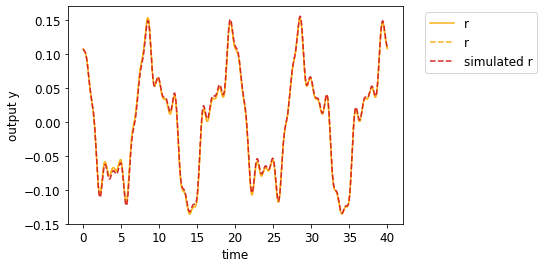

In [10]:
# plt.plot(t-5,DATA['TIME']['subject0']['condition0']['y'][i],label='measured y',color= colors['y'])
plt.plot(t-5,ref*scaleOutputScreen,label='r',color= colors['r'])
plt.plot(t-5,r*scaleOutputScreen,'--',label='r',color= colors['r'])


plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated r',color= colors['RED'])

# plt.plot(t_base,x_base[:,0]*scaleOutputScreen,'--',label='baseline y')

# plt.plot(t-5,HCPS['subject0']['condition0']['trial0']['state_'][:,0],label='state q')
plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [11]:
#EO trial 0 # _ = sum_of_sines(t, trial, x, frequencies, amplitudes, phase_shifts, derivative)

sines_r = np.arange(p_max[vf])[1::2]
shift_id = 0
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
p = phase_shifts_r[vf][shift_id][sines_r]
p = p.copy(); p.shape = (1,p.size)

r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)


In [12]:
#OE trial 0 # _ = sum_of_sines(t, trial, x, frequencies, amplitudes, phase_shifts, derivative)

sines_r = np.arange(p_max[vf])[0::2]
shift_id = 4
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
p = phase_shifts_r[vf][shift_id][sines_r]
p = p.copy(); p.shape = (1,p.size)

r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)


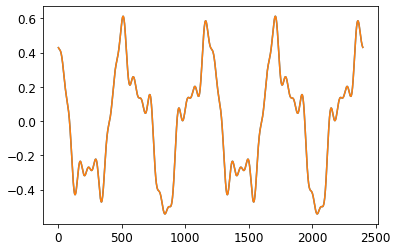

In [13]:
plt.plot(r)
plt.plot(DATA['TIME']['subject'+str(0)]['condition'+str(0)]['r'][9]/scaleOutputScreen)

# Simulation - empirical input u

## output sim

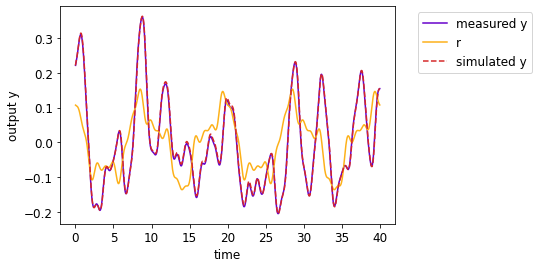

In [29]:
i = 9 #trial number

# x0_base = np.asarray([0,0])
x0 = np.asarray(HCPS['subject0']['condition0']['trial'+str(i)]['state_'][0])

# make "input" u+d
u_d = lambda t: (DATA['TIME']['subject0']['condition0']['u'][i][int(t/dt)] + DATA['TIME']['subject0']['condition0']['d'][i][int(t/dt)])/scaleInput
d = lambda t: (DATA['TIME']['subject0']['condition0']['d'][i][int(t/dt)])/scaleInput

def so(t,x,u):
  """
  second-order machine M
  # A = np.array([[0,1],[0,-b]])
  # B = np.array([[0],[1]])
  # C = np.array([1,0])
  """
  b = 1.0
  q,dq = x
  ddq = u
  return np.hstack((dq,ddq - b*dq))

t_base,x_base = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=d)
  
t_,x_ = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u_d)

plt.plot(t-5,DATA['TIME']['subject0']['condition0']['y'][i],label='measured y',color= colors['y'])
plt.plot(t-5,DATA['TIME']['subject0']['condition0']['r'][i],label='r',color= colors['r'])

plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated y',color= colors['RED'])

# plt.plot(t_base,x_base[:,0]*scaleOutputScreen,'--',label='baseline y')

# plt.plot(t-5,HCPS['subject0']['condition0']['trial0']['state_'][:,0],label='state q')
plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## histogram r,d

In [30]:
r = DATA['TIME']['subject0']['condition0']['r'][i]
d = DATA['TIME']['subject0']['condition0']['d'][i]
d = np.concatenate(d)

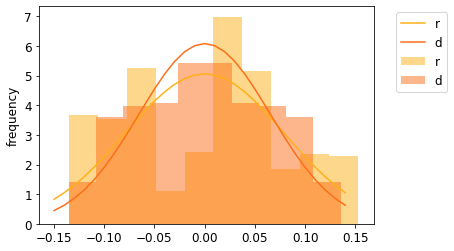

In [31]:
# bins=np.histogram(np.hstack((e_emgonly.flatten(),e_slideronly.flatten(),e_fusion50.flatten())), bins=50)[1] #get the bin edges
plt.hist(r,alpha=0.5,label = 'r',density=True,color=colors['r'])
plt.hist(d,alpha=0.5,density=True,label = 'd',color=colors['d'])

# Calculating mean and standard deviation
x_axis = np.arange(-0.15, 0.15, 1e-2)
mean_r = statistics.mean(r)
sd_r = statistics.stdev(r)
var_r = statistics.variance(r)
plt.plot(x_axis, norm.pdf(x_axis, mean_r, sd_r),label='r',color=colors['r'])

mean_d = statistics.mean(d)
sd_d = statistics.stdev(d)
var_d = statistics.variance(d)
plt.plot(x_axis, norm.pdf(x_axis, mean_d, sd_d),label='d',color=colors['d'])

# plt.title('tracking error (r-y)')
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

## delta1 and delta2 from 1-modality 

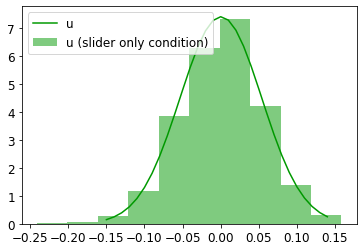

In [32]:
u = []
for i in range(trialnum[0]):
    u.append( DATA['TIME']['subject0']['condition0']['u'][i])
u = np.concatenate(u)

plt.hist(u,alpha=0.5,label = 'u (slider only condition)',density=True,color=colors['u'])

# Calculating mean and standard deviation
x_axis = np.arange(-0.15, 0.15, 1e-2)
mean_u = statistics.mean(u)
sd_u = statistics.stdev(u)
var_u = statistics.variance(u)
plt.plot(x_axis, norm.pdf(x_axis, mean_u, sd_u),label='u',color=colors['u'])
plt.legend()
plt.show()


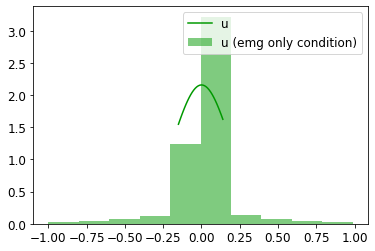

In [33]:
u = []
for i in range(trialnum[1]):
    u.append( DATA['TIME']['subject0']['condition1']['u'][i])
u = np.concatenate(u)

plt.hist(u,alpha=0.5,label = 'u (emg only condition)',density=True,color=colors['u'])

# Calculating mean and standard deviation
x_axis = np.arange(-0.15, 0.15, 1e-2)
mean_u = statistics.mean(u)
sd_u = statistics.stdev(u)
var_u = statistics.variance(u)
plt.plot(x_axis, norm.pdf(x_axis, mean_u, sd_u),label='u',color=colors['u'])
plt.legend()
plt.show()

# State space approach (old)

## LQR

In [34]:
n_state = 2
m_input = 2
b = 1

A = np.array([[0, 1],[0, -b]])
B = np.array([[0,0],[0.5,0.5]])
C = np.array([[-1,0]])
Q = np.identity(n_state) # running state cost
R = np.identity(m_input) # running control cost

W = np.array([[0, 0],[0, var_d]]) #cov of d
# V = var_r #cov of r

K,P,ELQ = ctrl.lqr(A,B,Q,R)
K

array([[0.70710678, 0.70710678],
       [0.70710678, 0.70710678]])

In [35]:
#simulation
def utx(t,x):
    r = np.asarray([DATA['TIME']['subject0']['condition0']['r'][i][int(t/dt)],0])
    U = K@(r-x)
    u = 0.5*U[0] + 0.5*U[1]
    return u

t_,x_ = numerical_simulation(so,T,x0,t0=0.,dt=dt,utx=utx)
error_ = DATA['TIME']['subject0']['condition0']['r'][i] - x_[:,0][:-1]*scaleOutputScreen  #y = r-Cx

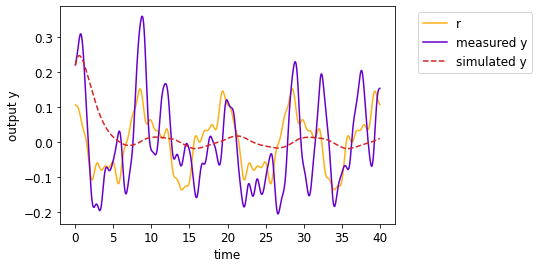

In [36]:
# plt.plot(t-5,,label='measured y',color= colors['y'])
plt.plot(t-5,DATA['TIME']['subject0']['condition0']['r'][i],label='r',color= colors['r'])
plt.plot(t-5,DATA['TIME']['subject0']['condition0']['y'][i],label='measured y',color= colors['y'])

plt.plot(t-5, x_[:,0][:-1]*scaleOutputScreen,'--',label='simulated y',color= colors['RED'])

plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

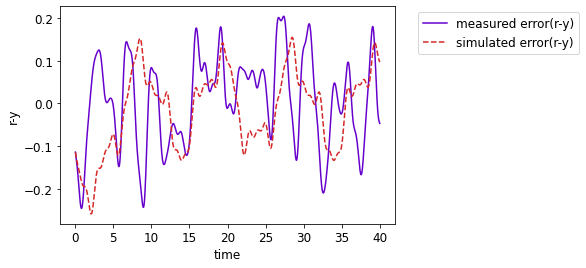

In [37]:
# plt.plot(t-5,,label='measured y',color= colors['y'])
plt.plot(t-5,DATA['TIME']['subject0']['condition0']['r'][i] - DATA['TIME']['subject0']['condition0']['y'][i],label='measured error(r-y)',color= colors['y'])

plt.plot(t-5,error_,'--',label='simulated error(r-y)',color= colors['RED'])

plt.xlabel('time')
plt.ylabel('r-y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## LQG

In [38]:
n_state = 2
m_input = 2
b = 1

A = np.array([[0, 1],[0, -b]])
B = np.array([[0,0],[0.5,0.5]])
C = np.array([[-1,0]])
Q = np.identity(n_state) # running state cost
R = np.identity(m_input) # running control cost

W = np.array([[0, 0],[0, var_d]]) #cov of d
V = var_r #cov of (-r)

In [39]:
K,P,ELQ = ctrl.lqr(A,B,Q,R)
L,S,EKF = ctrl.lqr(A.T,C.T,W,V)
K,L

(array([[0.70710678, 0.70710678],
        [0.70710678, 0.70710678]]),
 array([[-0.63211891, -0.19978716]]))

In [40]:
L.T

array([[-0.63211891],
       [-0.19978716]])

In [41]:
Ao = np.array([[-0.6321, 1],[-0.9069, -1.707]])
Bo = L.T
Co = -K

In [42]:
#simulation of "observer"
def observer(t,x,u):
  return np.dot(Ao,x) + np.dot(Bo,u)

t_,x_ = numerical_simulation(observer,T,x0,t0=0.,dt=dt,ux=ux)

NameError: name 'ux' is not defined

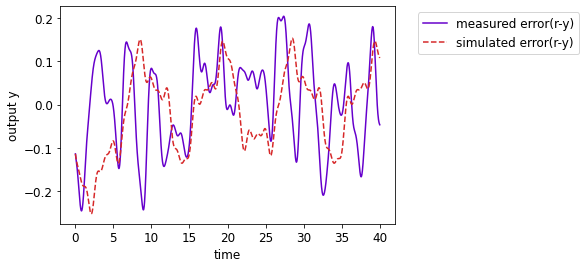

In [ ]:
#simulation
def ux(x):
    U = -K@x
    u = 0.5*U[0] + 0.5*U[1]
    return u

t_,x_ = numerical_simulation(so,T,x0,t0=0.,dt=dt,ux=ux)
y_ = DATA['TIME']['subject0']['condition0']['r'][i] - x_[:,0][:-1]*scaleOutputScreen  #y = r-Cx

# plt.plot(t-5,,label='measured y',color= colors['y'])
plt.plot(t-5,DATA['TIME']['subject0']['condition0']['r'][i] - DATA['TIME']['subject0']['condition0']['y'][i],label='measured error(r-y)',color= colors['y'])

plt.plot(t-5,y_,'--',label='simulated error(r-y)',color= colors['RED'])

plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Discrete time LQR

In [ ]:
# Discrete time functions
n_state = 2
m_input = 1
b = 1

def riccati_DT(A,B,Q,R,P):
    # optimal control is linear state feedback 
    K_ = np.dot( la.inv(np.dot(B.T,np.dot(P,B)) + R), np.dot(B.T,np.dot(P,A)) )
    # optimal value is quadratic in state
    P_ = np.dot( (A - np.dot(B,K_)).T, np.dot(P, (A - np.dot(B,K_))) + Q + np.dot(K_.T, np.dot(R, K_)) )
    return K_,P_

def lqr_DT(t,q=1,r=1,p=0, Delta=1e-1):
    
    A = np.identity(n_state) + Delta * np.array([[0, 1],[0, -b]])
    B = Delta * np.array([[0],[1]])
    Q = Delta * q * np.identity(n_state) # running state cost
    R = Delta * r * np.identity(m_input) # running control cost
    Pfinal = p * np.identity(n_state) # final state cost

    K = np.zeros((t, m_input, n_state)) # linear state feedback gain matrix
    P = np.zeros((t+1, n_state, n_state)) # cost-to-go
    P[t] = Pfinal

    # loop over times
    for s in range(t)[::-1]: # loop backward in time
        K[s],P[s] = riccati_DT(A,B,Q,R,P[s+1])
        
    return A,B,Q,R,K,P

In [ ]:
# variables
m, l, g, b = 1.,1.,9.81, 1. # kg, m, m/sec^2
T = np.rint(10 * np.sqrt(l/g)) # round up to nearest integer
delta = 5e-2
t = np.int_(T/delta)
t_ = np.arange(0, t+1)
p = 0
q = 1
r = 1

n_state = 2 # size of system state
m_input = 1 # size of input
dx0 = np.array([[np.pi/2],[0.0]])

du = np.zeros((t,m_input,1))
ct= np.zeros((t+1 ))
dx = np.zeros((t+1,n_state,1))
dx[0] = dx0

A,B,Q,R,K,P = lqr_DT(t,q=q,r=r,p=p)# find all the system matrices
for s in range(t):
  du[s] = np.dot(-K[s],dx[s])                        # calculate optimal input
  ct[s] = 0.5 * np.dot(dx[s].T, np.dot(Q, dx[s])) + \
        np.dot(du[s].T, np.dot(R, du[s]))  # calculate cost        
  dx[s+1] = np.dot(A,dx[s]) + np.dot(B, du[s])        # calculate next state
  if s == t:
    ct[s+1] = 0.5 * np.dot( dx[s+1].T, np.dot(P[s+1], dx[s+1]) )

c = np.cumsum(ct) # cummulative sum over timestep

# plot of x_bar and u_bar vs time
xlim = np.arange(0, t+1, 5).tolist()
fig = plt.figure(figsize=(8,8));

ax = plt.subplot(3,1,1)
plt.title(r'Plot of $\delta{x}$, $\delta{u}$ and c vs time')
plt.plot(t_, dx[:,0],linewidth=2,label=r'$\delta{q}$')
plt.plot(t_, dx[:,1],linewidth=2,label=r'$\dot{\delta{q}}$')
plt.ylabel(r'$\delta{x}$',fontsize=14)
plt.legend(fontsize=12)
plt.grid()

ax = plt.subplot(3,1,2)
plt.plot(t_[:-1],du[:,0],linewidth=2)
plt.ylabel(r'$\delta{u}$',fontsize=14)
plt.grid()

ax = plt.subplot(3,1,3)
plt.plot(t_, c,linewidth=2)
plt.ylabel(r'$c$',fontsize=14)
plt.xlabel(r'timestep ($\tau$)',fontsize=14)
plt.grid()

# Error space approach (1-dim u, condition 0)

## LQG - empirical input

In [145]:
n_state = 2
m_input = 1
b = 1
T = 40 #final simulation time 
t_all = HCPS['subject0']['condition0']['trial0']['time_'] - 5
dt = 1/fs #time steps (60Hz) 

A = np.array([[0, 1],[0, -b]])
B = np.array([[0],[1]])
C = np.array([[1,0]])
Q = np.identity(n_state) # running state cost
R = np.identity(m_input) # running control cost

In [147]:
p = 0
c = 0
i = 9
ref = DATA['TIME']['subject0']['condition0']['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject0']['condition0']['d'][i]/scaleInput 
input = DATA['TIME']['subject0']['condition0']['u'][i]/scaleInput 
output = DATA['TIME']['subject0']['condition0']['y'][i]/scaleOutputScreen
ry = ref-output #r-y


In [148]:
#derivitives
# dref = np.diff(ref,1)
# ddref = np.diff(ref,2)
# doutput = np.diff(output,1)
# dry = np.diff(ry,1) #dref - doutput

# ref_fun =  lambda t,x: DATA['TIME']['subject0']['condition0']['r'][i][int(t/dt)]
# dref = []
# for j in t_all[:-100]:
#     dref.append( rk_(ref_fun,t=j,x=0.,dt=1.) )
# ddref = np.diff(dref,1)
# j = 60
# ref_fun =  lambda t,x: DATA['TIME']['subject'+str(0)]['condition'+str(0)]['r'][i][int(t/dt)]
# dref_rk = []
# for jj in t_all[:-(j+1)]:
#     dref_rk.append( rk_(ref_fun,t=jj,x=0.,dt=1.) )

# dref = np.zeros((N))
# ddref = np.zeros((N))
# dref[:N-(j+1)] = dref_rk
# dref[-(j+1):] = np.diff(ref,1)[:(j+1)] #last 61 entry is from np.diff
# ddref[:(N-1)] = np.diff(dref,1) #last entry is 0

#derivatives
sines_r = np.arange(p_max[vf])[0::2] #OE trial 0
shift_id = i//2 #last trial 9
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
p = phase_shifts_r[vf][shift_id][sines_r]
p = p.copy(); p.shape = (1,p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)

In [157]:
#simulation
def rk_(f,t,x,dt):
    dx1 = f( t, x) * dt
    dx2 = f( t+.5*dt, x+.5*dx1) * dt
    dx3 = f( t+.5*dt, x+.5*dx2) * dt
    dx4 = f( t+dt, x+dx3) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]

def uM(t,x):
    # u = input[int(t/dt)]#-np.dot(K,x)
    uM = (- input[int(t/dt)] - dis[int(t/dt)])+ (b*dr[int(t/dt)] + ddr[int(t/dt)])
    return uM

def sys(t,x,u):
    dx = A@x + B@u
    return np.hstack((dx[0],dx[1]))

ry_fun = lambda t,x: (DATA['TIME']['subject0']['condition0']['r'][i][int(t/dt)]-DATA['TIME']['subject0']['condition0']['y'][i][int(t/dt)])/scaleOutputScreen #r-y
dry0 = rk_(ry_fun,t=0.,x=0.,dt=1.)

x0 = np.array([ry[0],dry0]) #(r-q,dr-dq)

t_,x_ = numerical_simulation(sys,T-dt,x0,t0=0.,dt=dt,utx=uM)

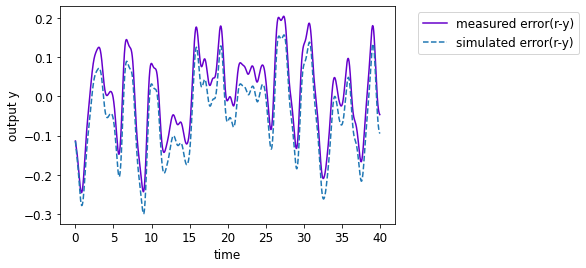

In [158]:
plt.plot(t_,ry*scaleOutputScreen,label='measured error(r-y)',color= colors['y'])

plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated error(r-y)')
# plt.plot(t_,x_[:,1]*scaleOutputScreen,'--',label='simulated error(dr-dy)')

plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## LQG: u_FB = -Kxh

In [256]:
def rk_(f,t,x,dt=1.):
    dx1 = f( t, x) * dt
    dx2 = f( t+.5*dt, x+.5*dx1) * dt
    dx3 = f( t+.5*dt, x+.5*dx2) * dt
    dx4 = f( t+dt, x+dx3) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]

p = 10
c = 2
i = 13
ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
input = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput
output = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen
ry = ref-output #r-y

dref = np.diff(ref,1)
ddref = np.diff(ref,2)
doutput = np.diff(output,1)
dry = np.diff(ry,1) #dref - doutput

ry_fun = lambda t,x: DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i][int(t/dt)]/scaleOutputScreen-DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i][int(t/dt)]/scaleOutputScreen #r-y
dry0 = rk_(ry_fun,t=0.,x=0.,dt=1.)

# dref = 38*np.diff(ref,1)
# ddref = 500*np.diff(ref,2)
# doutput = np.diff(output,1)
# dry = np.diff(ry,1) #dref - doutput

# dref = 10*np.gradient(ref,1)
# ddref = 10*np.gradient(ref,2)
# doutput = 10*np.gradient(output,1)
# dry = dref - doutput

In [257]:
n_state = 2
m_input = 1
b = 1
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 

A = np.array([[0, 1],[0, -b]])
B = np.array([[0],[1]])
C = np.array([[1,0]])
Q = np.identity(n_state) # running state cost
R = np.identity(m_input) # running control cost

#need to update these to incoperate: d, delta, eta (these are not WN)
W = 0.1*np.array([[0, 0],[0, 1]])#cov of delta (input dis)
V = 0.1 #cov of output distrubance 

K,P,ELQ = ctrl.lqr(A,B,Q,R)
L,S,EKF = ctrl.lqr(A.T,C.T,W,V)

mean = 0
std = np.sqrt(0.1)
delta = np.random.normal(mean, std, size=int(T/dt))
e = np.random.normal(mean, std, size=int(T/dt))

In [258]:
x0 = np.array([ry[0],dry0]) #(r-q,dr-dq)
xh = [x0]
y = [x0[0]]

def uFF_FB(t,x):
    uFB = -np.dot(K,xh[-1])
    uFF = (b*dref[int(t/dt)] + ddref[int(t/dt)])
    u = uFF + uFB 
    return u

def sys(t,x,u):
    dx = np.dot(A,x) + np.dot(B,u) + np.dot(B,np.array([delta[int(t/dt)]])) - np.dot(B,dis[int(t/dt)])
    y.append( np.dot(C,x) + e[int(t/dt)] )
    dxh = np.dot(A,xh[-1]) + np.dot(B,u) + np.dot(L.T,(y[-1]-C@xh[-1])) 
    xh.append( xh[-1] + dxh*dt )
    return np.hstack((dx[0],dx[1]))

t_,x_,u_ = numerical_simulation(sys,T-dt*2,x0,t0=0.,dt=dt,utx=uFF_FB,return_u=True)

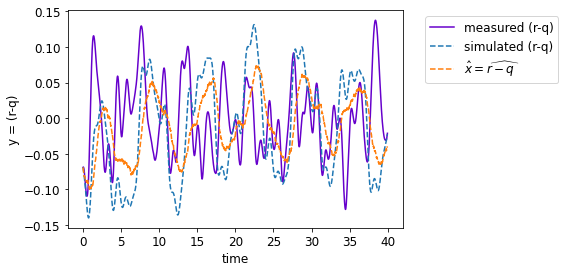

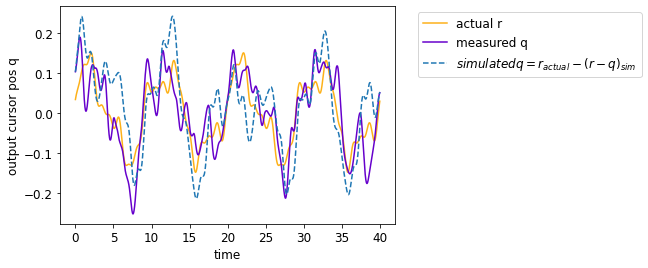

In [259]:
plt.plot(t_,ry[:-1]*scaleOutputScreen,label='measured (r-q)',color= colors['y'])
plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated (r-q)')
# y_ = np.asarray(y)
# plt.plot(t_,y_*scaleOutputScreen,'--',label='simulated y = r-q')
xh = np.asarray(xh)
plt.plot(t_,xh[:,0]*scaleOutputScreen,'--',label=r'$\hat{x} = \widehat{r-q}$')
plt.xlabel('time')
plt.ylabel('y = (r-q)') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#simulated -(r-y) -ref ; compare to meausred y
plt.plot(t_,ref[:-1]*scaleOutputScreen,label='actual r',color= colors['r'])
plt.plot(t_,output[:-1]*scaleOutputScreen,label='measured q',color= colors['y'])
plt.plot(t_,(-x_[:,0] + ref[:-1])*scaleOutputScreen,'--',label=r'$simulated q= r_{actual}-(r-q)_{sim}$')

plt.xlabel('time')
plt.ylabel('output cursor pos q') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

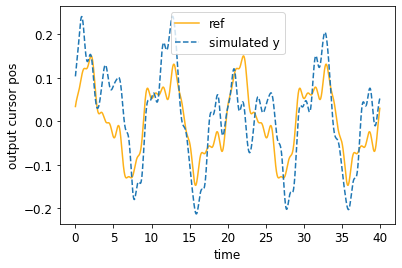

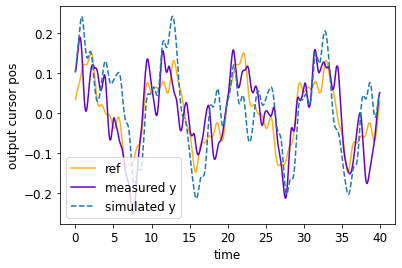

In [260]:
#plot for presentation
#simulated -(r-y) -ref ; compare to meausred y
plt.plot(t_,ref[:-1]*scaleOutputScreen,label='ref',color= colors['r'])
plt.plot(t_,(-x_[:,0] + ref[:-1])*scaleOutputScreen,'--',label='simulated y')

plt.xlabel('time')
plt.ylabel('output cursor pos') #ouput y is that state q = x[:,0]
plt.legend()
plt.show()

#plot for presentation
#simulated -(r-y) -ref ; compare to meausred y
plt.plot(t_,ref[:-1]*scaleOutputScreen,label='ref',color= colors['r'])
plt.plot(t_,output[:-1]*scaleOutputScreen,label='measured y',color= colors['y'])
plt.plot(t_,(-x_[:,0]+ ref[:-1])*scaleOutputScreen,'--',label='simulated y')

plt.xlabel('time')
plt.ylabel('output cursor pos') #ouput y is that state q = x[:,0]
plt.legend()
plt.show()

## LQG: with no disturbances (d,delta,eta)

In [350]:
def rk_(f,t,x,dt):
    dx1 = f( t, x) * dt
    dx2 = f( t+.5*dt, x+.5*dx1) * dt
    dx3 = f( t+.5*dt, x+.5*dx2) * dt
    dx4 = f( t+dt, x+dx3) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]
    
p = 0
c = 0
i = 9

#empirical data (measured)
ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
input = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput
output = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen
ry = ref-output #r-y

#derivitives
sines_r = np.arange(p_max[vf])[0::2] #OE trial 0
shift_id = i//2 #last trial 9
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
_p = phase_shifts_r[vf][shift_id][sines_r]
_p = _p.copy(); _p.shape = (1,_p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)

#find the derivative of the initial state with rk method
ry_fun = lambda t,x: (DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i][int(t/dt)]-DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i][int(t/dt)])/scaleOutputScreen #r-y
dry0 = rk_(ry_fun,t=0.,x=0.,dt=1.)


In [351]:
n_state = 2
m_input = 1
b = 1
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 

A = np.array([[0, 1],[0, -b]])
B = np.array([[0],[1]])
C = np.array([[1,0]])
Q = np.identity(n_state) # running state cost
R = np.identity(m_input) # running control cost

#need to update these to incoperate: d, delta, eta (these are not WN)
W = 0.01*np.array([[0, 0],[0, 1]])#cov of delta (input dis)
V = 0.01 #cov of output distrubance 

K,P,ELQ = ctrl.lqr(A,B,Q,R)
L,S,EKF = ctrl.lqr(A.T,C.T,W,V)

mean = 0
std = np.sqrt(0.1)
delta = np.random.normal(mean, std, size=len(t_))*0
e = np.random.normal(mean, std, size=len(t_))*0


In [360]:
x0 = np.array([ry[0],dry0]) #(r-q,dr-dq)
# x0 = np.array([0,dr[0]]) #(r,dr)

xh = [x0]
y = [x0[0]]

def uFF_FB(t,x):
    u = -K@xh[-1]
    # uFF = -(b*dr[int(t/dt)] + ddr[int(t/dt)])
    # u = uFF + uFB
    return u

def sys(t,x,u):
    dx = np.dot(A,x) + B@u #+ np.dot(B,np.array([delta[int(t/dt)]]))*0 - np.dot(B,dis[int(t/dt)])*0
    y.append( np.dot(C,x) )# + e[int(t/dt)]*0
    dxh = np.dot(A,xh[-1]) + B@u + np.dot(L.T,(y[-1]-C@xh[-1])) 
    xh.append( xh[-1] + dxh*dt )
    return np.hstack((dx[0],dx[1]))

t_,x_,u_ = numerical_simulation(sys,T-dt*2,x0,t0=0.,dt=dt,utx=uFF_FB,return_u=True)

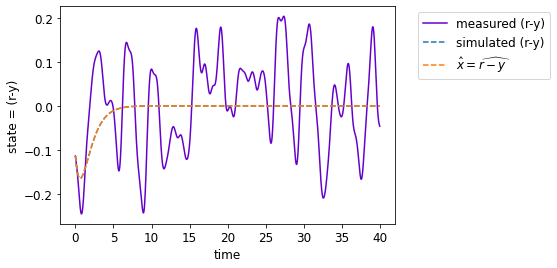

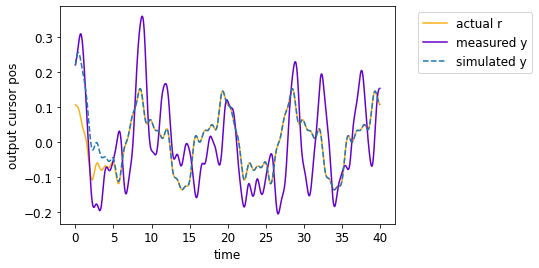

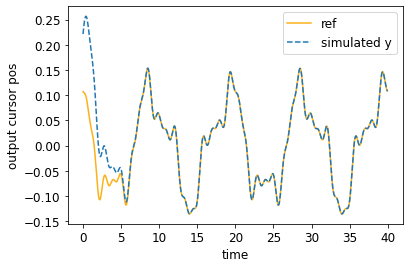

In [361]:
plt.plot(t_,ry[:-1]*scaleOutputScreen,label='measured (r-y)',color= colors['y'])
plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated (r-y)')
xh = np.asarray(xh)
plt.plot(t_,xh[:,0]*scaleOutputScreen,'--',label=r'$\hat{x} = \widehat{r-y}$')

plt.xlabel('time')
plt.ylabel('state = (r-y)') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#simulated -(r-y) -ref ; compare to meausred y
plt.plot(t_,ref[:-1]*scaleOutputScreen,label='actual r',color= colors['r'])
plt.plot(t_,output[:-1]*scaleOutputScreen,label='measured y',color= colors['y'])
plt.plot(t_,(-x_[:,0] + ref[:-1])*scaleOutputScreen,'--',label='simulated y') #r'$simulated q= r_{actual}-(r-q)_{sim}$'

plt.xlabel('time')
plt.ylabel('output cursor pos') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#plot for presentation
#simulated -(r-y) -ref ; compare to meausred y
plt.plot(t_,ref[:-1]*scaleOutputScreen,label='ref',color= colors['r'])
plt.plot(t_,(-x_[:,0] + ref[:-1])*scaleOutputScreen,'--',label='simulated y')

plt.xlabel('time')
plt.ylabel('output cursor pos') #ouput y is that state q = x[:,0]
plt.legend()
plt.show()


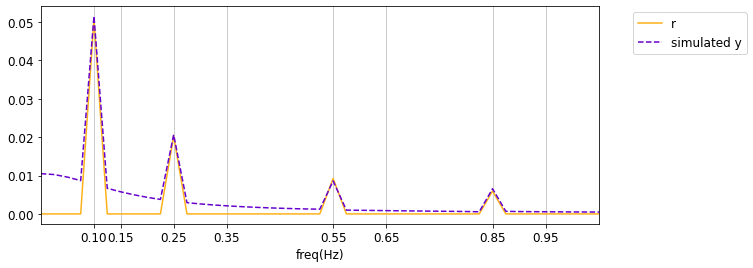

In [362]:
plt.figure(figsize=(10, 4))

for ii in prime: # prime multiples of a base frequency (1/20Hz)
    plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

R = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][i][:N//2] )
y_sim = np.abs( FFT((-x_[:,0] + ref[:-1])*scaleOutputScreen,N)[:N//2] ) #mag of FFT(uFB - uFF + uFF) 

plt.plot(xf,R, color=colors['r'],label='r') 
plt.plot(xf,y_sim,'--',label = 'simulated y',color = colors['y'])
plt.xlim((0,21*base_freq))
plt.xlabel('freq(Hz)')
plt.xticks(prime*0.05)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

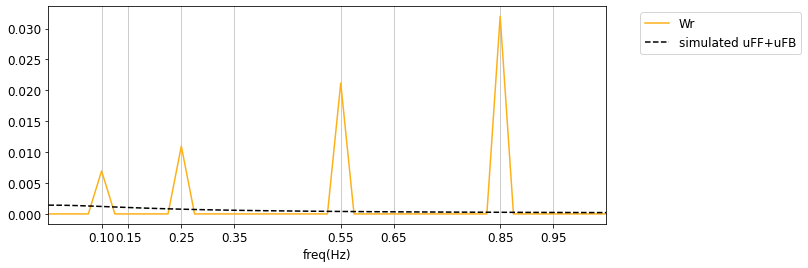

In [364]:
plt.figure(figsize=(10, 4))

for ii in prime: # prime multiples of a base frequency (1/20Hz)
    plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
uff = b*dr + ddr
u_sim = np.abs( FFT((np.concatenate(u_))*scaleInput,N)[:N//2] ) #mag of FFT(uFB + uFF) , u_total

plt.plot(xf,WR, color=colors['r'],label='Wr') 
plt.plot(xf,u_sim,'--',label = 'simulated uFF+uFB',color = 'black')
plt.xlim((0,21*base_freq))
plt.xlabel('freq(Hz)')
plt.xticks(prime*0.05)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

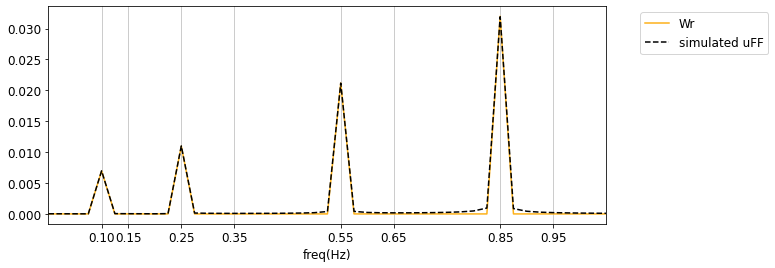

In [365]:
plt.figure(figsize=(10, 4))

for ii in prime: # prime multiples of a base frequency (1/20Hz)
    plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
uff = b*dr + ddr
u_sim = np.abs( FFT((uff[:-2])*scaleInput,N)[:N//2] ) #mag of FFT(uFB - uFF + uFF) 

plt.plot(xf,WR, color=colors['r'],label='Wr') 
plt.plot(xf,u_sim,'--',label = 'simulated uFF',color = 'black')
plt.xlim((0,21*base_freq))
plt.xlabel('freq(Hz)')
plt.xticks(prime*0.05)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

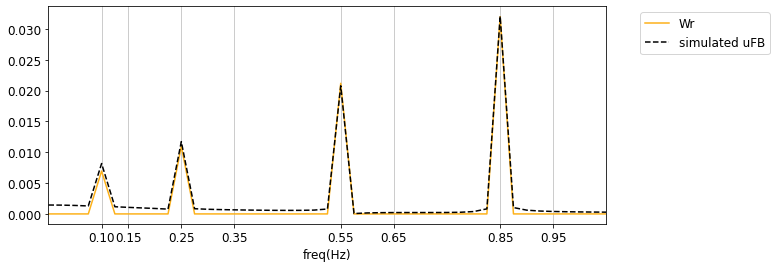

In [366]:
plt.figure(figsize=(10, 4))

for ii in prime: # prime multiples of a base frequency (1/20Hz)
    plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
uff = b*dr + ddr
u_sim = np.abs( FFT((np.concatenate(u_)-uff[:-2])*scaleInput,N)[:N//2] ) #mag of FFT(uFB = u_total - uFF) 

plt.plot(xf,WR, color=colors['r'],label='Wr') 
plt.plot(xf,u_sim,'--',label = 'simulated uFB',color = 'black')
plt.xlim((0,21*base_freq))
plt.xlabel('freq(Hz)')
plt.xticks(prime*0.05)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## perfect tracking & rejecting

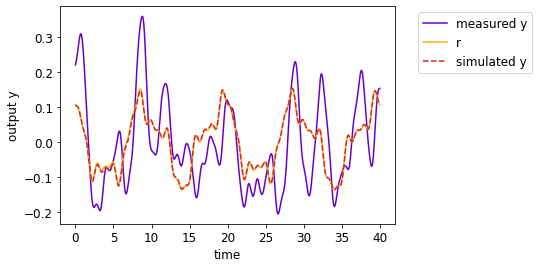

In [508]:
p = 0
c = 0
i = 9 #trial number #9

# x0_base = np.asarray([0,0])
# x0 = np.asarray(HCPS['subject0']['condition0']['trial'+str(i)]['state_'][0])
x0 = np.array([DATA['TIME']['subject0']['condition0']['r'][i][0]/scaleOutputScreen,-0.1])
# make "input" u+d
# u_d = lambda t: (DATA['TIME']['subject0']['condition0']['Wr'][i][int(t/dt)] + DATA['TIME']['subject0']['condition0']['d'][i][int(t/dt)])/scaleInput
u_d = lambda t: (DATA['TIME']['subject0']['condition0']['Wr'][i][int(t/dt)])/scaleInput #(Wr - d) + d

d = lambda t: (DATA['TIME']['subject0']['condition0']['d'][i][int(t/dt)])/scaleInput

def so(t,x,u):
  """
  second-order machine M
  # A = np.array([[0,1],[0,-b]])
  # B = np.array([[0],[1]])
  # C = np.array([1,0])
  """
  b = 1.0
  q,dq = x
  ddq = u
  return np.hstack((dq,ddq - b*dq))

# t_base,x_base = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=d)
  
t_,x_,u_ = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=u_d,return_u=True)

plt.plot(t-5,DATA['TIME']['subject0']['condition0']['y'][i],label='measured y',color= colors['y'])
plt.plot(t-5,DATA['TIME']['subject0']['condition0']['r'][i],label='r',color= colors['r'])

plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated y',color= colors['RED'])

# plt.plot(t_base,x_base[:,0]*scaleOutputScreen,'--',label='baseline y')

# plt.plot(t-5,HCPS['subject0']['condition0']['trial0']['state_'][:,0],label='state q')
plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

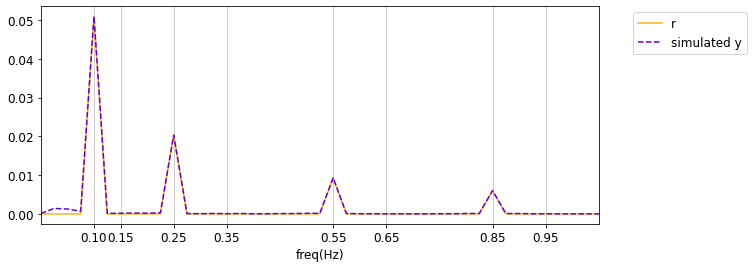

In [509]:
plt.figure(figsize=(10, 4))

for ii in prime: # prime multiples of a base frequency (1/20Hz)
    plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

R = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][i][:N//2] )
y_sim = np.abs( FFT((-x_[:,0])*scaleOutputScreen,N)[:N//2] ) #mag of FFT(uFB - uFF + uFF) 

plt.plot(xf,R, color=colors['r'],label='r') 
plt.plot(xf,y_sim,'--',label = 'simulated y',color = colors['y'])
plt.xlim((0,21*base_freq))
plt.xlabel('freq(Hz)')
plt.xticks(prime*0.05)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

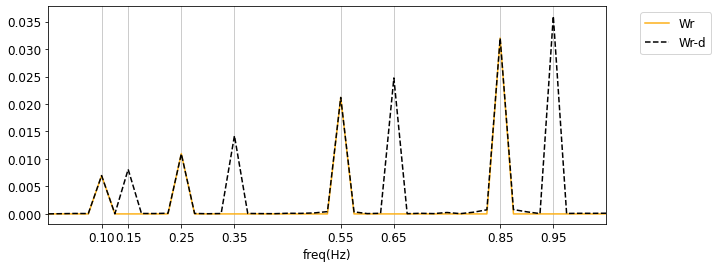

In [510]:
plt.figure(figsize=(10, 4))

for ii in prime: # prime multiples of a base frequency (1/20Hz)
    plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
ud_ = u_*scaleInput - DATA['TIME']['subject0']['condition0']['d'][i]
u_sim = np.abs( FFT(np.concatenate(ud_),N)[:N//2] )

plt.plot(xf,WR, color=colors['r'],label='Wr') 
plt.plot(xf,u_sim,'--',label = 'Wr-d',color = 'black')
plt.xlim((0,21*base_freq))
plt.xlabel('freq(Hz)')
plt.xticks(prime*0.05)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [511]:
WR

array([0.00000000e+00, 4.35944358e-19, 5.74847785e-19, ...,
       1.70566702e-14, 6.02721623e-15, 1.14401831e-14])

In [526]:
Even_index = np.array([ 6, 14, 26, 38])
U = FFT(np.concatenate(ud_),N)[:N//2]
D = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2] 
TUD_ = np.zeros(8, dtype=complex)
TUD_[::2] = U[Even_index] / D[Even_index]
TUD_

array([-1.00172565-0.004296j  ,  0.        +0.j        ,
       -0.9998915 -0.00053219j,  0.        +0.j        ,
       -0.99889647-0.00039926j,  0.        +0.j        ,
       -1.00902613-0.0009469j ,  0.        +0.j        ])

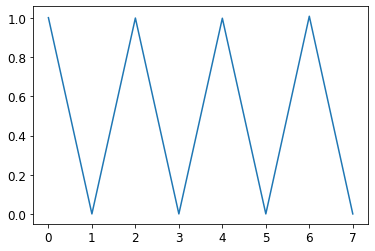

In [530]:
plt.plot(np.abs(TUD_)) #goal: 1

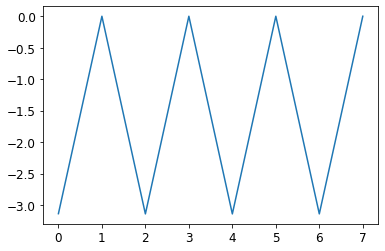

In [531]:
plt.plot(np.angle(TUD_)) #goal: pi

## LQG with empirical d (no delta, eta)

In [66]:
def rk_(f,t,x,dt=1.):
    dx1 = f( t, x) * dt
    dx2 = f( t+.5*dt, x+.5*dx1) * dt
    dx3 = f( t+.5*dt, x+.5*dx2) * dt
    dx4 = f( t+dt, x+dx3) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]

p = 10
c = 2
i = 13
ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
input = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput
output = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen
ry = ref-output #r-y

dref = np.diff(ref,1)
ddref = np.diff(ref,2)
doutput = np.diff(output,1)
dry = np.diff(ry,1) #dref - doutput

ry_fun = lambda t,x: DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i][int(t/dt)]/scaleOutputScreen-DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i][int(t/dt)]/scaleOutputScreen #r-y
dry0 = rk_(ry_fun,t=0.,x=0.,dt=1.)

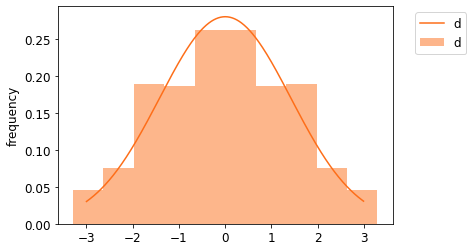

In [67]:
# bins=np.histogram(np.hstack((e_emgonly.flatten(),e_slideronly.flatten(),e_fusion50.flatten())), bins=50)[1] #get the bin edges
dis_ = np.concatenate(dis)
plt.hist(dis_,alpha=0.5,density=True,label = 'd',color=colors['d'])

# Calculating mean and standard deviation
x_axis = np.arange(-3, 3, 1e-2)
mean_d = statistics.mean(dis_)
sd_d = statistics.stdev(dis_)
var_d = statistics.variance(dis_)
plt.plot(x_axis, norm.pdf(x_axis, mean_d, sd_d),label='d',color=colors['d'])
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

In [69]:
n_state = 2
m_input = 1
b = 1
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 

A = np.array([[0, 1],[0, -b]])
B = np.array([[0],[1]])
C = np.array([[1,0]])
Q = np.identity(n_state) # running state cost
R = np.identity(m_input) # running control cost

#need to update these to incoperate: d, delta, eta (these are not WN)
# sd_delta = 0.05375512426593464
# var_delta = sd_delta**2
# W = np.array([[var_delta - var_d, 0],[0, var_delta - var_d]])#cov of delta (input dis), assume no covariance(u,d)
W = np.array([[0, 0],[0, var_d]])#cov of delta (input dis), assume no covariance(u,d)
V = 1e-4 #cov of output distrubance 

K,P,ELQ = ctrl.lqr(A,B,Q,R)
L,S,EKF = ctrl.lqr(A.T,C.T,W,V)

mean = 0
std = 1 
delta = np.random.normal(mean, std, size=N)*0
e = np.random.normal(mean, std, size=N)*0

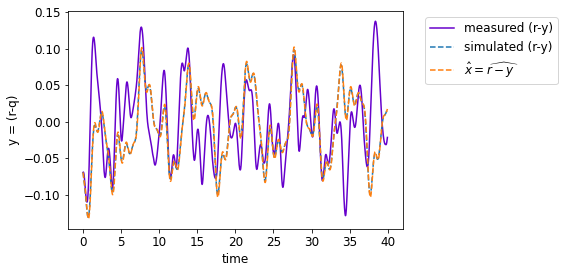

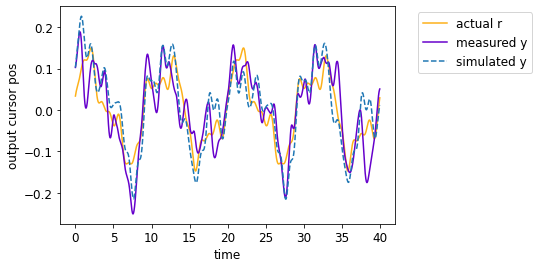

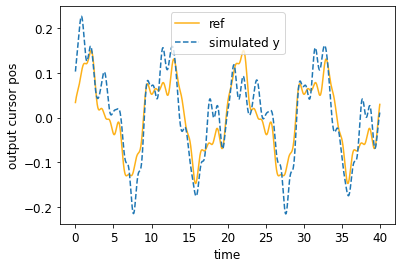

In [70]:
x0 = np.array([ry[0],dry0]) #(r-q,dr-dq)
xh = [x0]
y = [x0[0]]

def uFF_FB(t,x):
    uFB = -np.dot(K,xh[-1])
    uFF = (b*dref[int(t/dt)] + ddref[int(t/dt)])
    u = uFF + uFB 
    return u

def sys(t,x,u):
    dx = np.dot(A,x) + np.dot(B,u) + np.dot(B,np.array([delta[int(t/dt)]])) - np.dot(B,dis[int(t/dt)])
    y.append( np.dot(C,x) + e[int(t/dt)]*0 ) #no eta
    dxh = np.dot(A,xh[-1]) + np.dot(B,u) + np.dot(L.T,(y[-1]-C@xh[-1])) 
    xh.append( xh[-1] + dxh*dt )
    return np.hstack((dx[0],dx[1]))

t_,x_,u_ = numerical_simulation(sys,T-dt*2,x0,t0=0.,dt=dt,utx=uFF_FB,return_u=True)
plt.plot(t_,ry[:-1]*scaleOutputScreen,label='measured (r-y)',color= colors['y'])
plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated (r-y)')
xh = np.asarray(xh)
plt.plot(t_,xh[:,0]*scaleOutputScreen,'--',label=r'$\hat{x} = \widehat{r-y}$')

plt.xlabel('time')
plt.ylabel('y = (r-q)') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#simulated -(r-y) -ref ; compare to meausred y
plt.plot(t_,ref[:-1]*scaleOutputScreen,label='actual r',color= colors['r'])
plt.plot(t_,output[:-1]*scaleOutputScreen,label='measured y',color= colors['y'])
plt.plot(t_,(-x_[:,0] + ref[:-1])*scaleOutputScreen,'--',label='simulated y') #r'$simulated q= r_{actual}-(r-q)_{sim}$'
 
plt.xlabel('time')
plt.ylabel('output cursor pos') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#plot for presentation
#simulated -(r-y) -ref ; compare to meausred y
plt.plot(t_,ref[:-1]*scaleOutputScreen,label='ref',color= colors['r'])
plt.plot(t_,(-x_[:,0] + ref[:-1])*scaleOutputScreen,'--',label='simulated y')

plt.xlabel('time')
plt.ylabel('output cursor pos') #ouput y is that state q = x[:,0]
plt.legend()
plt.show()


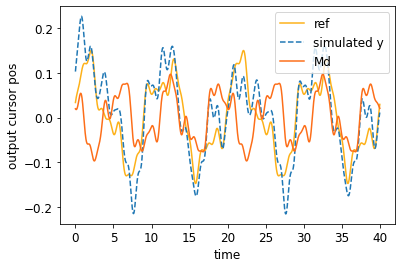

In [76]:
Md_data = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['Md'][i]/scaleOutputScreen 

plt.plot(t_,ref[:-1]*scaleOutputScreen,label='ref',color= colors['r'])
plt.plot(t_,(-x_[:,0] + ref[:-1])*scaleOutputScreen,'--',label='simulated y')
plt.plot(t_,Md_data[:-1]*scaleOutputScreen,label='Md',color= colors['d'])


plt.xlabel('time')
plt.ylabel('output cursor pos') #ouput y is that state q = x[:,0]
plt.legend()
plt.show()

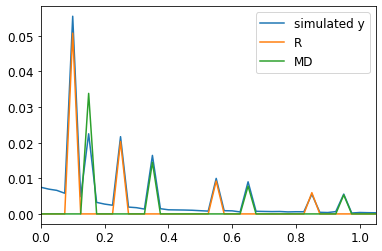

In [81]:
R = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][i]/scaleOutputScreen 
MD = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i]/scaleOutputScreen 

y_sim = (-x_[:,0] + ref[:-1])*scaleOutputScreen
Y_sim = FFT(y_sim,N)[:N//2]

plt.plot(xf,np.abs(Y_sim),label='simulated y')
plt.plot(xf,np.abs(R[:N//2]*scaleOutputScreen),label='R')
plt.plot(xf,np.abs(MD[:N//2]*scaleOutputScreen),label='MD')
plt.xlim((0,21*base_freq))
plt.legend()

## LQG with empirical d, delta (no eta)

In [733]:
def rk_(f,t,x,dt=1.):
    dx1 = f( t, x) * dt
    dx2 = f( t+.5*dt, x+.5*dx1) * dt
    dx3 = f( t+.5*dt, x+.5*dx2) * dt
    dx4 = f( t+dt, x+dx3) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]

p = 10
c = 2
i = 13
ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
input = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput
output = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen
ry = ref-output #r-y

dref = np.diff(ref,1)
ddref = np.diff(ref,2)
doutput = np.diff(output,1)
dry = np.diff(ry,1) #dref - doutput

ry_fun = lambda t,x: DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i][int(t/dt)]/scaleOutputScreen-DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i][int(t/dt)]/scaleOutputScreen #r-y
dry0 = rk_(ry_fun,t=0.,x=0.,dt=1.)

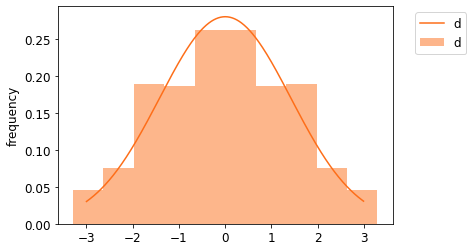

In [734]:
# empirical dis

# bins=np.histogram(np.hstack((e_emgonly.flatten(),e_slideronly.flatten(),e_fusion50.flatten())), bins=50)[1] #get the bin edges
dis_ = np.concatenate(dis)
plt.hist(dis_,alpha=0.5,density=True,label = 'd',color=colors['d'])

# Calculating mean and standard deviation
x_axis = np.arange(-3, 3, 1e-2)
mean_d = statistics.mean(dis_)
sd_d = statistics.stdev(dis_)
var_d = statistics.variance(dis_)
plt.plot(x_axis, norm.pdf(x_axis, mean_d, sd_d),label='d',color=colors['d'])
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

<ipython-input-735-f0d2c5d76da0>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  delta_[:len(avgdelta['subject'+str(p)]['condition'+str(c)])] = copy.copy(avgdelta['subject'+str(p)]['condition'+str(c)])


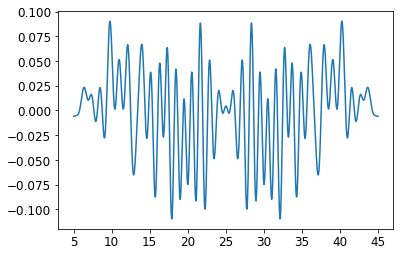

In [735]:
# empirical delta

delta_file = open("AvgDelta.pkl", "rb") #remember to close afterwards
avgdelta = pickle.load(delta_file)
delta_file.close()

delta_ = np.zeros((N))
delta_[:len(avgdelta['subject'+str(p)]['condition'+str(c)])] = copy.copy(avgdelta['subject'+str(p)]['condition'+str(c)])
delta_[0] = 0
delta_time = IFFT(delta_,N)/scaleInput
plt.plot(t,delta_time)

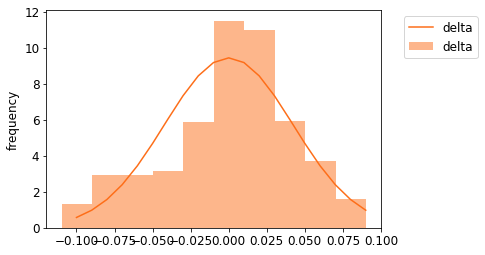

In [736]:
plt.hist(delta_time,alpha=0.5,density=True,label = 'delta',color=colors['d'])
x_axis = np.arange(-0.1, 0.1, 1e-2)
mean_delta = statistics.mean(delta_time)
sd_delta = statistics.stdev(delta_time)
var_delta = statistics.variance(delta_time)
plt.plot(x_axis, norm.pdf(x_axis, mean_delta, sd_delta),label='delta',color=colors['d'])
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

In [737]:
n_state = 2
m_input = 1
b = 1
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 

A = np.array([[0, 1],[0, -b]])
B = np.array([[0],[1]])
C = np.array([[1,0]])
Q = np.identity(n_state) # running state cost
R = np.identity(m_input) # running control cost

#need to update these to incoperate: d, delta, eta (these are not WN)
W = np.array([[0, 0],[0, var_d + var_delta]])#cov of delta (input dis), assume no covariance(u,d)
V = 1e-4 #cov of output distrubance 

K,P,ELQ = ctrl.lqr(A,B,Q,R)
L,S,EKF = ctrl.lqr(A.T,C.T,W,V)

delta = delta_time #np.random.normal(mean_delta, sd_delta, size=N)

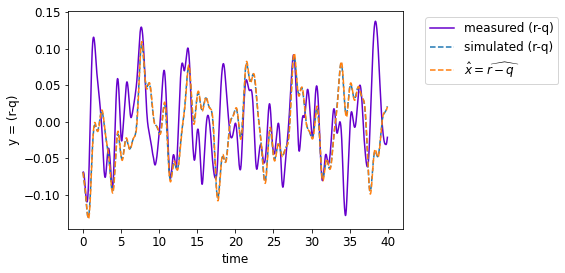

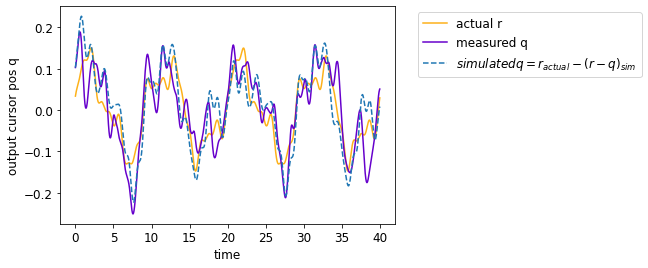

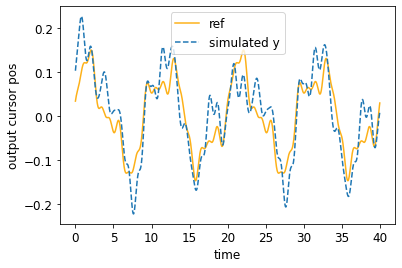

In [738]:
x0 = np.array([ry[0],dry0]) #(r-q,dr-dq)
xh = [x0]
y = [x0[0]]

def uFF_FB(t,x):
    uFB = -np.dot(K,xh[-1])
    uFF = (b*dref[int(t/dt)] + ddref[int(t/dt)])
    u = uFF + uFB 
    return u

def sys(t,x,u):
    dx = np.dot(A,x) + np.dot(B,u) + np.dot(B,np.array([delta[int(t/dt)]])) - np.dot(B,dis[int(t/dt)])
    y.append( np.dot(C,x) + e[int(t/dt)]*0 ) #no eta
    dxh = np.dot(A,xh[-1]) + np.dot(B,u) + np.dot(L.T,(y[-1]-C@xh[-1])) 
    xh.append( xh[-1] + dxh*dt )
    return np.hstack((dx[0],dx[1]))

t_,x_,u_ = numerical_simulation(sys,T-dt*2,x0,t0=0.,dt=dt,utx=uFF_FB,return_u=True)
plt.plot(t_,ry[:-1]*scaleOutputScreen,label='measured (r-q)',color= colors['y'])
plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated (r-q)')
xh = np.asarray(xh)
plt.plot(t_,xh[:,0]*scaleOutputScreen,'--',label=r'$\hat{x} = \widehat{r-q}$')

plt.xlabel('time')
plt.ylabel('y = (r-q)') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#simulated -(r-y) -ref ; compare to meausred y
plt.plot(t_,ref[:-1]*scaleOutputScreen,label='actual r',color= colors['r'])
plt.plot(t_,output[:-1]*scaleOutputScreen,label='measured q',color= colors['y'])
plt.plot(t_,(-x_[:,0] + ref[:-1])*scaleOutputScreen,'--',label=r'$simulated q= r_{actual}-(r-q)_{sim}$')

plt.xlabel('time')
plt.ylabel('output cursor pos q') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#plot for presentation
#simulated -(r-y) -ref ; compare to meausred y
plt.plot(t_,ref[:-1]*scaleOutputScreen,label='ref',color= colors['r'])
plt.plot(t_,(-x_[:,0] + ref[:-1])*scaleOutputScreen,'--',label='simulated y')

plt.xlabel('time')
plt.ylabel('output cursor pos') #ouput y is that state q = x[:,0]
plt.legend()
plt.show()


## 2-dim u (condition 2)

In [124]:
def rk_(f,t,x,dt=1.):
    dx1 = f( t, x) * dt
    dx2 = f( t+.5*dt, x+.5*dx1) * dt
    dx3 = f( t+.5*dt, x+.5*dx2) * dt
    dx4 = f( t+dt, x+dx3) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]

p = 10 #subject number
c = 2 #condition number
i = 13 #trial number
ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
input = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput
output = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen
ry = ref-output #r-y

#derivitives
sines_r = np.arange(p_max[vf])[0::2] #OE trial 13
shift_id = i//2 #last trial 13
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
_p = phase_shifts_r[vf][shift_id][sines_r]
_p = _p.copy(); _p.shape = (1,_p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)

uff = b*dr + ddr

ry_fun = lambda t,x: DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i][int(t/dt)]/scaleOutputScreen-DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i][int(t/dt)]/scaleOutputScreen #r-y
dry0 = rk_(ry_fun,t=0.,x=0.,dt=1.)

In [125]:
#empirical dis
dis_ = np.concatenate(dis)
mean_d = statistics.mean(dis_)
sd_d = statistics.stdev(dis_)
var_d = statistics.variance(dis_)

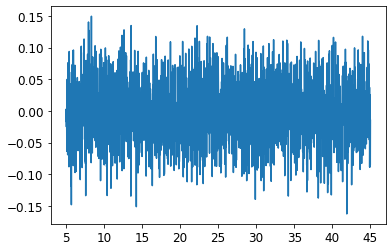

In [126]:
# empirical delta from slider only condition0
# delta_slider = np.zeros((N))
# delta_slider[:len(avgdelta['avgdelta_time']['subject'+str(p)]['slider'])] = copy.copy(avgdelta['avgdelta_time']['subject'+str(p)]['slider'])
# delta_slider[0] = 0
# delta_time_slider = IFFT(delta_slider,N)/scaleInput

delta_time_slider = avgdelta['avgdelta_time']['subject'+str(p)]['slider'] #time domain noise (from slider-only) for each participant
mean_delta_slider = statistics.mean(delta_time_slider)
sd_delta_slider = statistics.stdev(delta_time_slider)
var_delta_slider = statistics.variance(delta_time_slider)

plt.plot(t,delta_time_slider)
plt.show() 

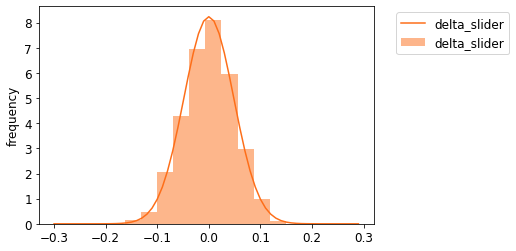

In [127]:
plt.hist(delta_time_slider,alpha=0.5,density=True,label = 'delta_slider',color=colors['d'])
x_axis = np.arange(-0.3, 0.3, 1e-2)
mean_delta_slider = statistics.mean(delta_time_slider)
sd_delta_slider = statistics.stdev(delta_time_slider)
var_delta_slider = statistics.variance(delta_time_slider)
plt.plot(x_axis, norm.pdf(x_axis, mean_delta_slider, sd_delta_slider),label='delta_slider',color=colors['d'])
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

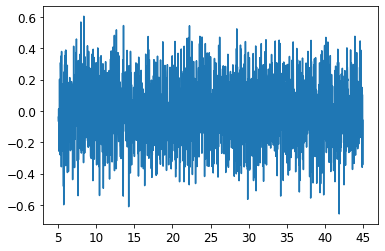

In [128]:
# empirical delta from emg only condition1
# delta_emg = np.zeros((N))
# delta_emg[:len(avgdelta['subject'+str(p)]['emg'])] = copy.copy(avgdelta['subject'+str(p)]['emg'])
# delta_emg[0] = 0
# delta_time_emg = IFFT(delta_emg,N)/scaleInput
delta_time_emg = avgdelta['avgdelta_time']['subject'+str(p)]['emg'] #time domain noise (from emg-only) for each participant
mean_delta_emg = statistics.mean(delta_time_emg)
sd_delta_emg = statistics.stdev(delta_time_emg)
var_delta_emg = statistics.variance(delta_time_emg)

plt.plot(t,delta_time_emg)
plt.show() 

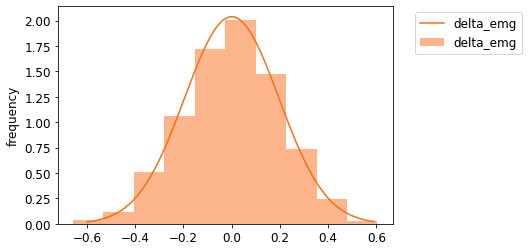

In [129]:
plt.hist(delta_time_emg,alpha=0.5,density=True,label = 'delta_emg',color=colors['d'])
x_axis = np.arange(-0.6, 0.6, 1e-2)
mean_delta_emg = statistics.mean(delta_time_emg)
sd_delta_emg = statistics.stdev(delta_time_emg)
var_delta_emg = statistics.variance(delta_time_emg)
plt.plot(x_axis, norm.pdf(x_axis, mean_delta_emg, sd_delta_emg),label='delta_emg',color=colors['d'])
plt.ylabel('frequency')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show() 

In [130]:
# empirical delta (sensorimotor noise) from slider only condition0
# delta_slider = np.zeros((N))
# delta_slider[:len(avgdelta['subject'+str(p)]['slider'])] = copy.copy(avgdelta['subject'+str(p)]['slider'])
# delta_slider[0] = 0
# delta_time_slider = IFFT(delta_slider,N)/scaleInput
# mean_delta_slider = statistics.mean(delta_time_slider)
# sd_delta_slider = statistics.stdev(delta_time_slider)
# var_delta_slider = statistics.variance(delta_time_slider)

# # empirical delta (sensorimotor noise) from emg only condition1
# delta_emg = np.zeros((N))
# delta_emg[:len(avgdelta['subject'+str(p)]['emg'])] = copy.copy(avgdelta['subject'+str(p)]['emg'])
# delta_emg[0] = 0
# delta_time_emg = IFFT(delta_emg,N)/scaleInput
# mean_delta_emg = statistics.mean(delta_time_emg)
# sd_delta_emg = statistics.stdev(delta_time_emg)
# var_delta_emg = statistics.variance(delta_time_emg)

# #create Gaussian delta0 and delta1
# delta0 = np.random.normal(mean_delta_emg, sd_delta_emg, size=N) #from emg only
# delta1 = np.random.normal(mean_delta_slider, sd_delta_slider, size=N) #from slider only


In [131]:
n_state = 2
m_input = 2
b = 1
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
weight = 0.5 #condition2 - 50% EMG

A = np.array([[0, 1],[0, -b]])
B = np.array([[0, 0],[weight, weight]])
B_ = np.array([[0],[1]])
C = np.array([[1,0]])
Q = np.identity(n_state) # running state cost
R = np.identity(m_input) # running control cost

#need to update these to incoperate: d, delta, eta (these are not WN)
W = np.array([[0, 0],[0, var_d + 0.25*var_delta_emg + 0.25*var_delta_slider]])#cov of delta (input dis), assume no covariance(u,d)
V = 1e-4 #cov of output distrubance 

K,P,ELQ = ctrl.lqr(A,B,Q,R)
L,S,EKF = ctrl.lqr(A.T,C.T,W,V)

#empiriccal delta
delta0 = np.random.normal(mean_delta_emg, sd_delta_emg, size=N) #from emg only
delta1 = np.random.normal(mean_delta_slider, sd_delta_slider, size=N) #from slider only

#no eta
mean = 0
std = np.sqrt(0.1)
e = np.random.normal(mean, std, size=len(t_))*0

In [132]:
var_delta_emg

0.03829124359572813

In [165]:
x0 = np.array([ry[0],dry0]) #(r-q,dr-dq)
xh = [x0]
y = [x0[0]]

def uFF_FB(t,x):
    # uff = -(b*dr[int(t/dt)] + ddr[int(t/dt)])
    # uFF = np.array([uff,uff])
    u = -np.dot(K,xh[-1])
    return u

def sys(t,x,u):
    uff = np.array(-(b*dr[int(t/dt)] + ddr[int(t/dt)]))
    delta = np.array([delta0[int(t/dt)],delta1[int(t/dt)]])
    dx = np.dot(A,x) + np.dot(B,u) + np.dot(B,delta) - np.dot(B_,dis[int(t/dt)]) + np.dot(B_,uff).flatten()
    y.append( np.dot(C,x) ) #no eta
    dxh = np.dot(A,xh[-1]) + np.dot(B,u) + np.dot(L.T,(y[-1]-C@xh[-1])) 
    xh.append( xh[-1] + dxh*dt )
    return np.hstack((dx[0],dx[1]))

t_,x_,u_ = numerical_simulation(sys,T-dt*2,x0,t0=0.,dt=dt,utx=uFF_FB,return_u=True)

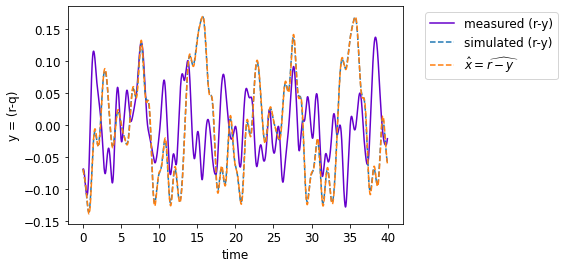

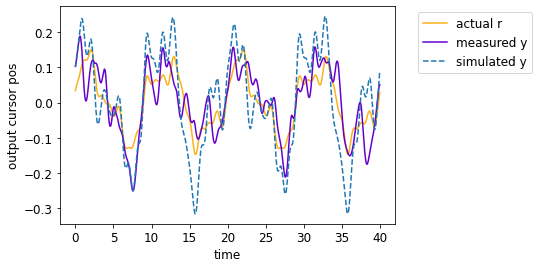

In [166]:

plt.plot(t_,ry[:-1]*scaleOutputScreen,label='measured (r-y)',color= colors['y'])
plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated (r-y)')
xh = np.asarray(xh)
plt.plot(t_,xh[:,0]*scaleOutputScreen,'--',label=r'$\hat{x} = \widehat{r-y}$')

plt.xlabel('time')
plt.ylabel('y = (r-q)') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#simulated -(r-y) -ref ; compare to meausred y
plt.plot(t_,ref[:-1]*scaleOutputScreen,label='actual r',color= colors['r'])
plt.plot(t_,output[:-1]*scaleOutputScreen,label='measured y',color= colors['y'])
plt.plot(t_,(-x_[:,0] + ref[:-1])*scaleOutputScreen,'--',label='simulated y') #r'$simulated q= r_{actual}-(r-q)_{sim}$'

plt.xlabel('time')
plt.ylabel('output cursor pos') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


## sim plots

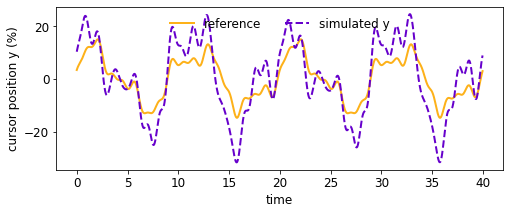

In [167]:
#plot for presentation
#simulated -(r-y) -ref ; compare to meausred y
plt.figure(figsize=(8, 3))
plt.plot(t_,100*ref[:-1]*scaleOutputScreen,label='reference',color= colors['r'],linewidth=2,)
plt.plot(t_,100*(-x_[:,0] + ref[:-1])*scaleOutputScreen,'--',label='simulated y',color= colors['y'],linewidth=2)

plt.xlabel('time')
plt.ylabel('cursor position y (%)') #ouput y is that state q = x[:,0]
# plt.legend(bbox_to_anchor=(0.5, -0.4), loc='lower center', ncol=2, frameon=False)
plt.legend(loc='upper center', ncol=2, frameon=False)
plt.savefig('output.png', dpi=300, bbox_inches='tight')
plt.show()

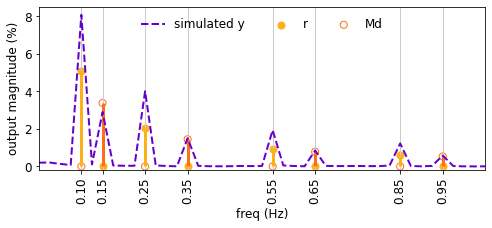

In [172]:
plt.figure(figsize=(8, 3))

plt.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8')
# for ii in prime: # prime multiples of a base frequency (1/20Hz)
#     plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

r = np.abs( FFT(ref*scaleOutputScreen,N)[:N//2] )
MD = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i][:N//2] )
y_sim = np.abs( FFT((-x_[:,0] + ref[:-1])*scaleOutputScreen,N)[:N//2] )

# plt.plot(xf,r,'o', color=colors['r'],label='r') #reference
# plt.plot(xf,MD, 'o',color=colors['d'],label='Md', mfc='none')
plt.scatter(xf[stimulated_index],100*r[stimulated_index], color=colors['r'],label='r',s=50)
plt.scatter(xf[stimulated_index],100*MD[stimulated_index], color=colors['d'],label='Md',facecolors='none',s=50)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*r[stimulated_index],color=colors['r'],linewidth = 3)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*MD[stimulated_index],color=colors['d'],linewidth = 3)

plt.plot(xf,100*y_sim,'--',label = 'simulated y',color = colors['y'],linewidth = 2)
plt.xlim((0,21*base_freq))
plt.ylim((-0.2,8.5))
plt.xlabel('freq (Hz)')
plt.ylabel('output magnitude (%)')
plt.xticks(prime*0.05,rotation = 90)
plt.legend( loc='upper center', ncol=3, frameon=False)
plt.savefig('output freq.png', dpi=300, bbox_inches='tight')
plt.show()

In [174]:
#derivitives
sines_r = np.arange(p_max[vf])[0::2] #OE trial 13
shift_id = i//2 #last trial 13
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
_p = phase_shifts_r[vf][shift_id][sines_r]
_p = _p.copy(); _p.shape = (1,_p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)

uff = b*dr + ddr

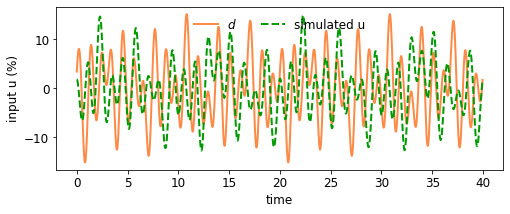

In [176]:
#plot for presentation
plt.figure(figsize=(8, 3))
d = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]
plt.plot(t_[:-1],100*d[:-2],label=r'$d$',color= colors['d'],linewidth=2,alpha = 0.8)

u_total = -( weight*(u_[:,0]+u_[:,1]) +uff[:-2])*scaleInput #u = -(uFB+uFF)
plt.plot(t_[:-1],100*u_total,'--',label='simulated u',color= colors['u'],linewidth=2)

plt.xlabel('time')
plt.ylabel('input u (%)') #ouput y is that state q = x[:,0]
plt.legend(loc='upper center', ncol=2, frameon=False)
plt.savefig('input.png', dpi=300, bbox_inches='tight')
plt.show()

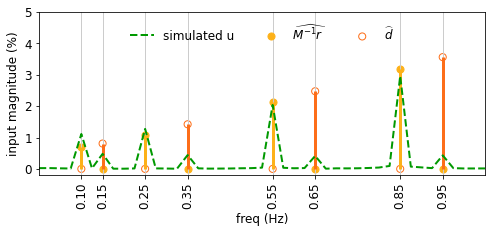

In [178]:
plt.figure(figsize=(8, 3))

plt.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8')
WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
D = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2] )
u_sim = np.abs( FFT( u_total ,N )[:N//2] ) #mag of FFT(-uFB = -u_total + uFF) 

plt.plot(xf,100*u_sim,'--',label = 'simulated u',color = colors['u'],linewidth = 2)
plt.scatter(xf[stimulated_index],100*WR[stimulated_index], color=colors['r'],label=r'$\widehat{M^{-1}r}$',s=50)
plt.scatter(xf[stimulated_index],100*D[stimulated_index], color=colors['d'],label=r'$\widehat{d}$',facecolors='none',s=50)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*WR[stimulated_index],color=colors['r'],linewidth = 3)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*D[stimulated_index],color=colors['d'],linewidth = 3)
plt.xlim((0,21*base_freq))
plt.ylim((-0.2,5))
plt.xlabel('freq (Hz)')
plt.ylabel('input magnitude (%)')
plt.xticks(prime*0.05,rotation = 90)
plt.legend( loc='upper center', ncol=3, frameon=False)
plt.savefig('input freq.png', dpi=300, bbox_inches='tight')
plt.show()

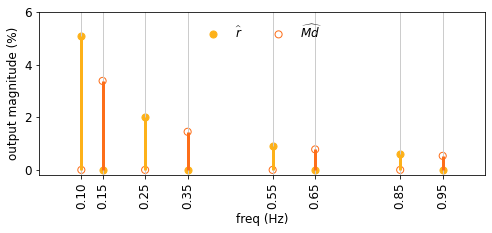

In [408]:
plt.figure(figsize=(8, 3))

plt.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8')
r = np.abs( FFT(ref*scaleOutputScreen,N)[:N//2] )
MD = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i][:N//2] )
plt.scatter(xf[stimulated_index],100*r[stimulated_index], color=colors['r'],label=r'$\widehat{r}$',s=50)
plt.scatter(xf[stimulated_index],100*MD[stimulated_index], color=colors['d'],label=r'$\widehat{Md}$',facecolors='none',s=50)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*r[stimulated_index],color=colors['r'],linewidth = 3)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*MD[stimulated_index],color=colors['d'],linewidth = 3)
plt.xlim((0,21*base_freq))
plt.ylim((-0.2,6))
plt.xlabel('freq (Hz)')
plt.ylabel('output magnitude (%)')
plt.xticks(prime*0.05,rotation = 90)
plt.legend( loc='upper center', ncol=3, frameon=False)
plt.show()

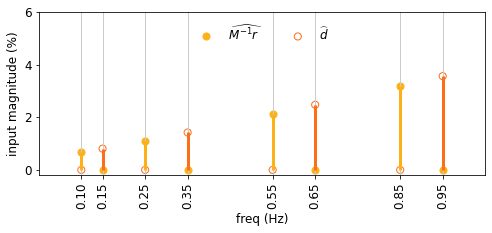

In [409]:
plt.figure(figsize=(8, 3))

plt.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8')
WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
D = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2] )
plt.scatter(xf[stimulated_index],100*WR[stimulated_index], color=colors['r'],label=r'$\widehat{M^{-1}r}$',s=50)
plt.scatter(xf[stimulated_index],100*D[stimulated_index], color=colors['d'],label=r'$\widehat{d}$',facecolors='none',s=50)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*WR[stimulated_index],color=colors['r'],linewidth = 3)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*D[stimulated_index],color=colors['d'],linewidth = 3)
plt.xlim((0,21*base_freq))
plt.ylim((-0.2,6))
plt.xlabel('freq (Hz)')
plt.ylabel('input magnitude (%)')
plt.xticks(prime*0.05,rotation = 90)
plt.legend( loc='upper center', ncol=3, frameon=False)
plt.show()

In [795]:
#simulated time domain error vs. measured r-y
LA.norm(x_[:,0]*scaleOutputScreen) #state x is in error coordiniate

2.584681043053788

In [796]:
LA.norm(ry[:-1]*scaleOutputScreen)

2.647650373231845

# LQG simulation with avg delta across all participants

In [14]:
# 2-dim u (condition 2)
def rk_(f,t,x,dt):
    dx1 = f( t, x) * dt
    dx2 = f( t+.5*dt, x+.5*dx1) * dt
    dx3 = f( t+.5*dt, x+.5*dx2) * dt
    dx4 = f( t+dt, x+dx3) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]

n_state = 2
m_input = 2
b = 1
t_all = HCPS['subject0']['condition0']['trial0']['time_'] - 5
T = 40 #final simulation time 
dt = 1/fs #time steps (60Hz) 
weight = 0.5 #condition2 - 50% EMG

#LQG of the fusion condition2
def LQG_SIM(p,c,i):   #subject number #condition number #trial number
    
    #empirical data (measured)
    ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
    dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
    input = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput
    output = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen
    ry = ref-output #r-y

    #derivitives
    sines_r = np.arange(p_max[vf])[0::2] #OE trial 13
    shift_id = i//2 #last trial 13
    _t = np.asarray(t).copy(); _t.shape = (_t.size,1)
    o = np.ones(_t.shape)
    f = frequencies_r[vf][sines_r]
    f = f.copy(); f.shape = (1,f.size)
    a = amplitudes_r[vf][sines_r]
    a = a.copy(); a.shape = (1,a.size)
    _p = phase_shifts_r[vf][shift_id][sines_r]
    _p = _p.copy(); _p.shape = (1,_p.size)
    r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
    dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
    ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)

    #find the derivative of the initial state with rk method
    ry_fun = lambda t,x: DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i][int(t/dt)]/scaleOutputScreen-DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i][int(t/dt)]/scaleOutputScreen #r-y
    dry0 = rk_(ry_fun,t=0.,x=0.,dt=1.)
    
    #empirical dis (mean, std, var)
    dis_ = np.concatenate(dis)
    mean_d = statistics.mean(dis_)
    sd_d = statistics.stdev(dis_)
    var_d = statistics.variance(dis_)

    # empirical delta (sensorimotor noise) from slider only condition0
    # delta_slider = np.zeros((N))
    # delta_slider[:len(avgdelta['subject'+str(p)]['slider'])] = copy.copy(avgdelta['subject'+str(p)]['slider'])
    # delta_slider[0] = 0
    # delta_time_slider = IFFT(delta_slider,N)/scaleInput
    delta_time_slider = avgdelta['avgdelta_time']['subject'+str(p)]['slider'] #time domain noise (from slider-only) for each participant
    mean_delta_slider = statistics.mean(delta_time_slider)
    sd_delta_slider = statistics.stdev(delta_time_slider)
    var_delta_slider = statistics.variance(delta_time_slider)

    # empirical delta (sensorimotor noise) from emg only condition1
    # delta_emg = np.zeros((N))
    # delta_emg[:len(avgdelta['subject'+str(p)]['emg'])] = copy.copy(avgdelta['subject'+str(p)]['emg'])
    # delta_emg[0] = 0
    # delta_time_emg = IFFT(delta_emg,N)/scaleInput
    delta_time_emg = avgdelta['avgdelta_time']['subject'+str(p)]['emg'] #time domain noise (from emg-only) for each participant
    mean_delta_emg = statistics.mean(delta_time_emg)
    sd_delta_emg = statistics.stdev(delta_time_emg)
    var_delta_emg = statistics.variance(delta_time_emg)

    #create Gaussian delta0 and delta1
    delta0 = np.random.normal(mean_delta_emg, sd_delta_emg, size=N) #from emg only
    delta1 = np.random.normal(mean_delta_slider, sd_delta_slider, size=N) #from slider only

    # LQG of fusion condition
    A = np.array([[0, 1],[0, -b]])
    B = np.array([[0, 0],[weight, weight]])
    B_ = np.array([[0],[1]])
    C = np.array([[1,0]])
    Q = np.identity(n_state) # running state cost
    R = np.identity(m_input) # running control cost
    W = np.array([[0, 0],[0, var_d + (weight**2)*var_delta_emg + (weight**2)*var_delta_slider]])#cov of delta (input dis), assume no covariance(u,d)
    # W = np.array([[0,0],[0,1e-4]])
    V = 1e-4 #cov of output distrubance 
    K,_,_ = ctrl.lqr(A,B,Q,R)
    L,_,_ = ctrl.lqr(A.T,C.T,W,V)

    #initial state
    x0 = np.array([ry[0],dry0]) #(r-q,dr-dq)
    xh = [x0]
    y = [x0[0]]

    def uFF_FB(t,x):
        # uff = b*dr[int(t/dt)] + ddr[int(t/dt)]
        # uFF = np.array([uff,uff])
        u = -np.dot(K,xh[-1])
        return u

    def sys(t,x,u):
        # uff = np.array(-(b*dr[int(t/dt)] + ddr[int(t/dt)]))
        delta = np.array([delta0[int(t/dt)],delta1[int(t/dt)]])
        dx = np.dot(A,x) + np.dot(B,u) + np.dot(B,delta) - np.dot(B_,dis[int(t/dt)]) #+ np.dot(B_,uff).flatten()
        y.append( np.dot(C,x) ) #no eta
        dxh = np.dot(A,xh[-1]) + np.dot(B,u) + np.dot(L.T,(y[-1]-C@xh[-1])) 
        xh.append( xh[-1] + dxh*dt )
        return np.hstack((dx[0],dx[1]))

    t_,x_,u_ = numerical_simulation(sys,T-dt,x0,t0=0.,dt=dt,utx=uFF_FB,return_u=True)

    return t_,x_,u_,xh

In [256]:
c = 2 #condition number
i = 13 #trial number
x_all = []
u_all = []
xh_all = []

out_all = []
out0_all = []
out1_all = []

in_all = []
in0_all = []
in1_all = []

for p in range(participants_num): #subject number
    c = 2 #condition number
    i = 13 #trial number

    t_,x_,u_,xh = LQG_SIM(p,c,i)
    x_all.append(x_) #simulated
    u_all.append(u_) #simulated
    xh_all.append(xh) #simulated (estimation x)
    
    for i in range(1,trialnum[c],2):   #OE
        out_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen ) #measured
        out0_all.append( SIM['subject'+str(p)]['condition'+str(c)]['y0'][i]/scaleOutputScreen ) #measured
        out1_all.append( SIM['subject'+str(p)]['condition'+str(c)]['y1'][i]/scaleOutputScreen ) #measured

        in_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput ) #measured
        in0_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i]/scaleInput ) #measured
        in1_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i]/scaleInput ) #measured


In [257]:
#sim data
x_all_mean = np.mean(x_all, axis=0)
u_all_mean = np.mean(u_all, axis=0) #this is "-u" because u was measured in error coordinates, i.e. -uFB

#measured data
c = 2 #condition number
i = 13 #trial number
ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
out_all_mean = np.mean(out_all, axis=0)
out_all_75 = np.percentile(out_all, 75, axis=0)
out_all_25 = np.percentile(out_all, 25, axis=0)
out0_all_mean = np.mean(out0_all, axis=0)
out0_all_75 = np.percentile(out0_all, 75, axis=0)
out0_all_25 = np.percentile(out0_all, 25, axis=0)
out1_all_mean = np.mean(out1_all, axis=0)
out1_all_75 = np.percentile(out1_all, 75, axis=0)
out1_all_25 = np.percentile(out1_all, 25, axis=0)

in_all_mean = np.mean(in_all, axis=0)
in_all_75 = np.percentile(in_all, 75, axis=0)
in_all_25 = np.percentile(in_all, 25, axis=0)
in0_all_mean = np.mean(in0_all, axis=0)
in0_all_75 = np.percentile(in0_all, 75, axis=0)
in0_all_25 = np.percentile(in0_all, 25, axis=0)
in1_all_mean = np.mean(in1_all, axis=0)
in1_all_75 = np.percentile(in1_all, 75, axis=0)
in1_all_25 = np.percentile(in1_all, 25, axis=0)

## plots

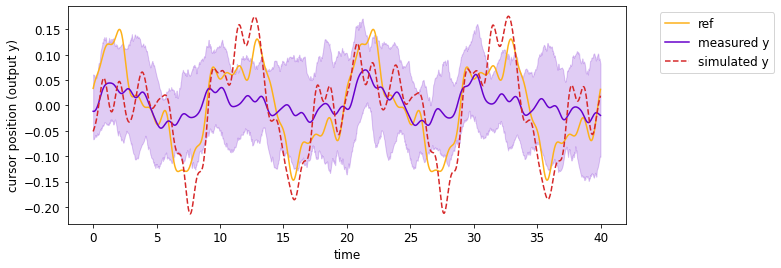

In [258]:
c = 2 #condition number
i = 13 #trial number

plt.figure(figsize=(10, 4))
plt.plot(t_,ref*scaleOutputScreen,label='ref',color= colors['r']) #ref is the same for all participants
plt.plot(t_,out_all_mean*scaleOutputScreen,label='measured y',color= colors['y'])
plt.fill_between(t_,out_all_25*scaleOutputScreen,out_all_75*scaleOutputScreen, facecolor=yfill,alpha=0.2,edgecolor=colors['y'])
plt.plot(t_,(-x_all_mean[:,0] + ref)*scaleOutputScreen,'--',color= colors['RED'],label='simulated y')

plt.xlabel('time')
plt.ylabel('cursor position (output y)') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

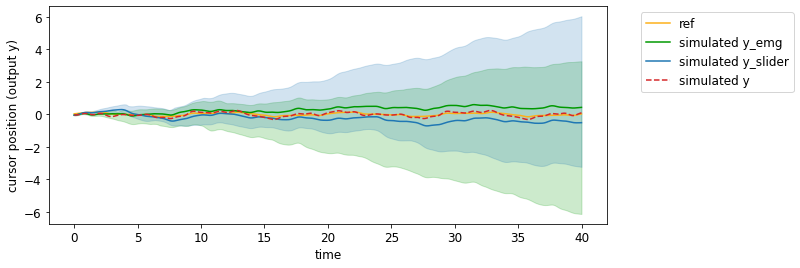

In [187]:
plt.figure(figsize=(10, 4))
plt.plot(t_,ref*scaleOutputScreen,label='ref',color= colors['r']) #ref is the same for all participants
plt.plot(t_,out0_all_mean*scaleOutputScreen,label='simulated y_emg',color= colors['u'])
plt.fill_between(t_,out0_all_25*scaleOutputScreen,out0_all_75*scaleOutputScreen, facecolor=ufill,alpha=0.2,edgecolor=colors['u'])

plt.plot(t_,out1_all_mean*scaleOutputScreen,label='simulated y_slider',color = colors['BLUE'])
plt.fill_between(t_,out1_all_25*scaleOutputScreen,out1_all_75*scaleOutputScreen, facecolor=bfill,alpha=0.2,edgecolor=colors['BLUE'])

plt.plot(t_,(-x_all_mean[:,0] + ref)*scaleOutputScreen,'--',color= colors['RED'],label='simulated y')

plt.xlabel('time')
plt.ylabel('cursor position (output y)') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

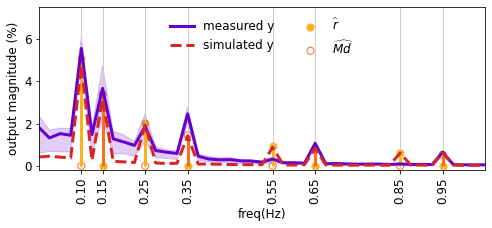

In [259]:
# plt.figure(figsize=(10, 4))
plt.figure(figsize=(8, 3))

# for ii in prime: # prime multiples of a base frequency (1/20Hz)
#     plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')
plt.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8')

r = np.abs( FFT(ref*scaleOutputScreen,N)[:N//2] )
MD = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i][:N//2] )
y_sim = np.abs( FFT((-x_all_mean[:,0] + ref)*scaleOutputScreen,N)[:N//2] )

# y_measure = [np.abs(FFT((out_all[i])*scaleOutputScreen,N)[:N//2]) for i in range(participants_num*trialnum[c]//2)] 
Y_measure = []
for p in range(participants_num): #subject number
    for i in range(1,trialnum[c],2):  #OE/EO
        Y_measure.append( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y'][i][:N//2]) )
y_mean = np.mean(Y_measure,axis =0)
y_75 = np.percentile(Y_measure,75,axis =0)
y_25 = np.percentile(Y_measure,25,axis =0)
# y_mean = np.abs( FFT(out_all_mean*scaleOutputScreen,N)[:N//2] )
# y_75 = np.abs( FFT(out_all_75*scaleOutputScreen,N)[:N//2] )
# y_25 = np.abs( FFT(out_all_25*scaleOutputScreen,N)[:N//2] )

# plt.plot(xf,r*100, color=colors['r'],label='r',linewidth = 3) #reference
# plt.plot(xf,MD*100, color=colors['d'],label='Md',linewidth = 3)
plt.scatter(xf[stimulated_index],100*r[stimulated_index], color=colors['r'],label=r'$\widehat{r}$',s=50)
plt.scatter(xf[stimulated_index],100*MD[stimulated_index], color=colors['d'],label=r'$\widehat{Md}$',facecolors='none',s=50)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*r[stimulated_index],color=colors['r'],linewidth = 3)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*MD[stimulated_index],color=colors['d'],linewidth = 3)

plt.plot(xf,y_mean*100, color=colors['y'],label='measured y',linewidth = 3)
plt.fill_between(xf,y_25*100,y_75*100, facecolor=yfill,edgecolor=colors['y'],alpha=0.2)
plt.plot(xf,y_sim*100,'--',label = 'simulated y',color = colors['RED'],linewidth = 3)
plt.xlim((0,21*base_freq))
plt.ylim((-0.2,7.5))
plt.ylabel('output magnitude (%)')
plt.xlabel('freq(Hz)')
plt.xticks(prime*0.05,rotation = 90)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend( loc='upper center', ncol=2, frameon=False)
plt.show()

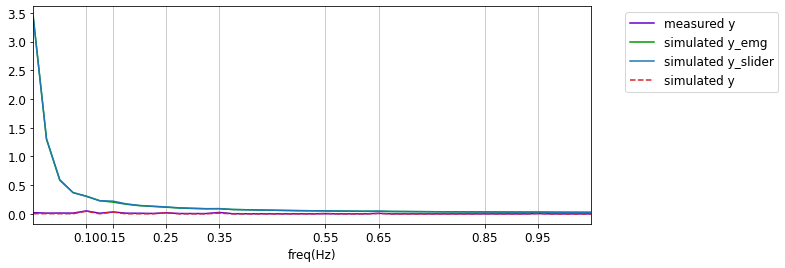

In [20]:
plt.figure(figsize=(10, 4))

for ii in prime: # prime multiples of a base frequency (1/20Hz)
    plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

r = np.abs( FFT(ref*scaleOutputScreen,N)[:N//2] )
MD = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['MD'][i][:N//2] )
y_sim = np.abs( FFT((-x_all_mean[:,0] + ref)*scaleOutputScreen,N)[:N//2] )

y0_measure = [np.abs(FFT((out0_all[i])*scaleOutputScreen,N)[:N//2]) for i in range(participants_num)] #mag of FFT(uFB)
y0_mean = np.mean(y0_measure,axis =0)
y0_75 = np.percentile(y0_measure,75,axis =0)
y0_25 = np.percentile(y0_measure,25,axis =0)

y1_measure = [np.abs(FFT((out1_all[i])*scaleOutputScreen,N)[:N//2]) for i in range(participants_num)] #mag of FFT(uFB)
y1_mean = np.mean(y1_measure,axis =0)
y1_75 = np.percentile(y1_measure,75,axis =0)
y1_25 = np.percentile(y1_measure,25,axis =0)

# y_mean = np.abs( FFT(out_all_mean*scaleOutputScreen,N)[:N//2] )
# # y_75 = np.abs( FFT(out_all_75*scaleOutputScreen,N)[:N//2] )
# # y_25 = np.abs( FFT(out_all_25*scaleOutputScreen,N)[:N//2] )
# y0_mean = np.abs( FFT(out0_all_mean*scaleOutputScreen,N)[:N//2] )
# y1_mean = np.abs( FFT(out1_all_mean*scaleOutputScreen,N)[:N//2] )

# plt.plot(xf,r, color=colors['r'],label='r') #reference
# plt.plot(xf,MD, color=colors['d'],label='Md')

plt.plot(xf,y_mean, color=colors['y'],label='measured y')
plt.plot(xf,y0_mean, color=colors['u'],label='simulated y_emg')
plt.plot(xf,y1_mean, color=colors['BLUE'],label='simulated y_slider')

# plt.fill_between(xf,y_25,y_75, facecolor=yfill,edgecolor=colors['y'])
plt.plot(xf,y_sim,'--',label = 'simulated y',color = colors['RED'])
plt.xlim((0,21*base_freq))

plt.xlabel('freq(Hz)')
plt.xticks(prime*0.05)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [260]:
#derivitives
sines_r = np.arange(p_max[vf])[0::2] #OE trial 13 #EO trial 12 is [1::2]
shift_id = i//2 #last trial 13
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
_p = phase_shifts_r[vf][shift_id][sines_r]
_p = _p.copy(); _p.shape = (1,_p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)

uff = b*dr + ddr

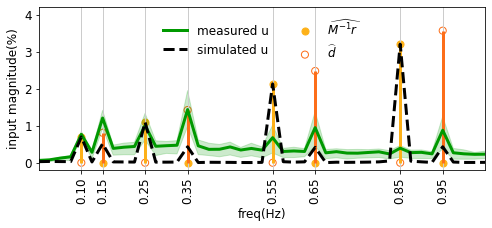

In [261]:
plt.figure(figsize=(8, 3))

plt.vlines(xf[stimulated_index],ymin=-0.3, ymax=10,linewidth=1, color='0.8')

u_total = -( weight*(u_all_mean[:,0]+u_all_mean[:,1]) +uff[:-1])*scaleInput #u = -(uFB+uFF)
u_sim = np.abs( FFT( u_total ,N )[:N//2] ) #mag of FFT(-uFB = -u_total + uFF) 

# u_measure = [np.abs(FFT((in_all[i])*scaleInput,N)[:N//2]) for i in range(participants_num)] #mag of FFT(uFB)
U_measure = []
for p in range(participants_num): #subject number
    for i in range(1,trialnum[c],2):  #EO / OE
        U_measure.append( np.abs(DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][i][:N//2]) )
u_mean = np.mean(U_measure,axis =0)
u_75 = np.percentile(U_measure,75,axis =0)
u_25 = np.percentile(U_measure,25,axis =0)

# WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
# d = np.abs( FFT(dis*scaleInput,N)[:N//2] )
# plt.plot(xf,d, color=colors['d'],label='d',linewidth = 3) 
# plt.plot(xf,WR, color=colors['r'],label='Wr',linewidth = 3) 
WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
D = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][i][:N//2] )
plt.scatter(xf[stimulated_index],100*WR[stimulated_index], color=colors['r'],label=r'$\widehat{M^{-1}r}$',s=50)
plt.scatter(xf[stimulated_index],100*D[stimulated_index], color=colors['d'],label=r'$\widehat{d}$',facecolors='none',s=50)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*WR[stimulated_index],color=colors['r'],linewidth = 3)
plt.vlines(xf[stimulated_index],np.zeros((len(stimulated_freq),)),100*D[stimulated_index],color=colors['d'],linewidth = 3)

plt.plot(xf,u_mean*100, color=colors['u'],label='measured u',linewidth = 3)
plt.fill_between(xf,u_25*100,u_75*100, facecolor=ufill,edgecolor=colors['u'],alpha=0.2)
plt.plot(xf,u_sim*100,'--',label = 'simulated u',color = 'black',linewidth = 3) #this is uFB!!!
# plt.plot(xf,np.abs(FFT(uff*scaleInput,N)[:N//2]))
plt.xlim((0,21*base_freq))
plt.ylim((-0.2,4.2))
plt.ylabel('input magnitude(%)')
plt.xlabel('freq(Hz)')
plt.xticks(prime*0.05,rotation = 90)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend( loc='upper center', ncol=2, frameon=False)
plt.show()

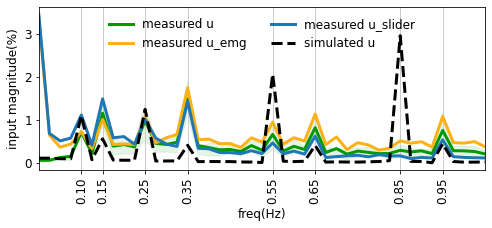

In [194]:
plt.figure(figsize=(8, 3))

for ii in prime: # prime multiples of a base frequency (1/20Hz)
    plt.axvline(x = ii*base_freq,linewidth=1, color='0.8')

WR = np.abs( DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['WR'][i][:N//2] )
d = np.abs( FFT(dis*scaleInput,N)[:N//2] )
u_total = -( weight*(u_all_mean[:,0]+u_all_mean[:,1]) +uff[:-1])*scaleInput #u = -(uFB+uFF)
u_sim = np.abs( FFT( u_total ,N )[:N//2] ) #mag of FFT(-uFB = -u_total + uFF) 

u0_measure = [np.abs(FFT((in0_all[i])*scaleInput,N)[:N//2]) for i in range(participants_num)] #mag of FFT(uFB)
u0_mean = np.mean(u0_measure,axis =0)
u0_75 = np.percentile(u0_measure,75,axis =0)
u0_25 = np.percentile(u0_measure,25,axis =0)

u1_measure = [np.abs(FFT((in1_all[i])*scaleInput,N)[:N//2]) for i in range(participants_num)] #mag of FFT(uFB)
u1_mean = np.mean(u1_measure,axis =0)
u1_75 = np.percentile(u1_measure,75,axis =0)
u1_25 = np.percentile(u1_measure,25,axis =0)

# plt.plot(xf,d, color=colors['d'],label='d') 
# plt.plot(xf,WR, color=colors['r'],label='Wr') 
plt.plot(xf,u_mean*100, color=colors['u'],label='measured u',linewidth = 3)
plt.plot(xf,u0_mean*100, color=colors['r'],label='measured u_emg',linewidth = 3)
plt.plot(xf,u1_mean*100, color=colors['BLUE'],label='measured u_slider',linewidth = 3)

plt.fill_between(xf,u_25*100,u_75*100, facecolor=ufill,edgecolor=colors['u'],alpha=0.1)
plt.plot(xf,u_sim*100,'--',label = 'simulated u',color = 'black',linewidth = 3)
plt.xlim((0,21*base_freq))

plt.xlabel('freq(Hz)')
plt.ylabel('input magnitude(%)')
plt.xticks(prime*0.05,rotation = 90)
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend( loc='upper center', ncol=2, frameon=False)
plt.show()

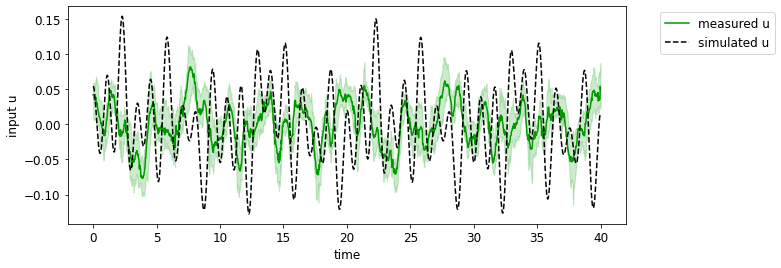

In [195]:
plt.figure(figsize=(10, 4))
Wr = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['Wr'][i][:-2]
# plt.plot(t_[:-1], Wr,label='Wr',color= colors['r'])
# plt.plot(t_[:-1], dis[:-2]*scaleInput,label='d',color= colors['d'])
plt.plot(t_, in_all_mean*scaleInput,label='measured u',color= colors['u'])
plt.fill_between(t_,in_all_25*scaleInput, in_all_75*scaleInput, facecolor=ufill,alpha=0.2,edgecolor=colors['u'])
plt.plot(t_[:-1], u_total,'--',label='simulated u',color= 'black') 

plt.xlabel('time')
plt.ylabel('input u') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


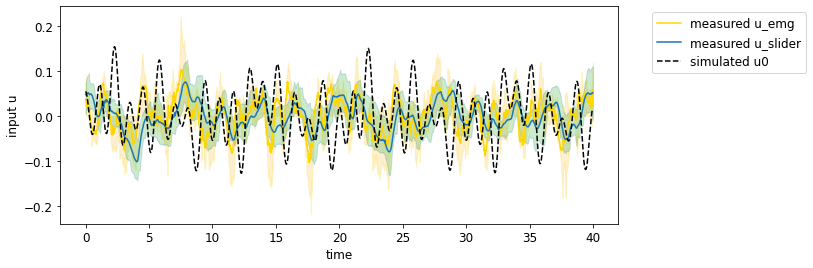

In [196]:
plt.figure(figsize=(10, 4))
Wr = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['Wr'][i][:-2]
# plt.plot(t_[:-1], Wr,label='Wr',color= colors['r'])
# plt.plot(t_[:-1], dis[:-2]*scaleInput,label='d',color= colors['d'])
plt.plot(t_, in0_all_mean*scaleInput,label='measured u_emg',color= 'gold')
plt.fill_between(t_,in0_all_25*scaleInput, in0_all_75*scaleInput, facecolor=rfill,alpha=0.2,edgecolor='gold')

plt.plot(t_, in1_all_mean*scaleInput,label='measured u_slider',color= colors['BLUE'])
plt.fill_between(t_,in1_all_25*scaleInput, in1_all_75*scaleInput, facecolor=ufill,alpha=0.2,edgecolor=colors['BLUE'])

plt.plot(t_[:-1], u_total,'--',label='simulated u0',color= 'black') 

plt.xlabel('time')
plt.ylabel('input u') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [26]:
#simulation cost vs. actual cost (in error coordinate)
c_ = LA.norm( (-x_all_mean[:,0])*scaleOutputScreen) + LA.norm((weight*(u_all_mean[:,0]+u_all_mean[:,1])+uff[:-1])*scaleInput)
c_

5.4878131974245035

In [27]:
c = LA.norm((out_all_mean - ref)*scaleOutputScreen) + LA.norm( in_all_mean*scaleInput )
c

4.690313735231145

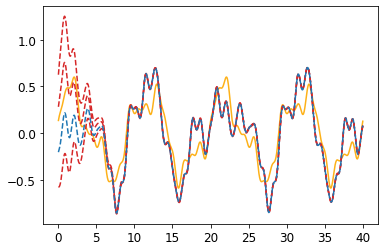

In [28]:
#different initial conditions for the simulated y:
plt.plot(t_all,ref,color = colors['r'])
plt.plot(t_all,-x_all[0][:,0]+ref,'--',color = colors['RED'])
plt.plot(t_all,-x_all[1][:,0]+ref,'--',color = colors['RED'])
plt.plot(t_all,-x_all[2][:,0]+ref,'--',color = colors['RED'])

plt.plot(t_all,-x_all_mean[:,0]+ref,'--',color = colors['BLUE'])


## Tud and Tyr of simulated LQG

In [15]:
c = 2 #condition number
i = 12 #trial number
x_all0 = []
u_all0 = []
xh_all0 = []

# out_all = []
# out0_all = []
# out1_all = []

# in_all = []
# in0_all = []
# in1_all = []

for p in range(participants_num): #subject number
    t_,x_,u_,xh = LQG_SIM(p,c,i)
    x_all0.append(x_) #simulated
    u_all0.append(u_) #simulated
    xh_all0.append(xh) #simulated (estimation x)

    # out_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen ) #measured
    # out0_all.append( SIM['subject'+str(p)]['condition'+str(c)]['y0'][i]/scaleOutputScreen ) #measured
    # out1_all.append( SIM['subject'+str(p)]['condition'+str(c)]['y1'][i]/scaleOutputScreen ) #measured

    # in_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput ) #measured
    # in0_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u0'][i]/scaleInput ) #measured
    # in1_all.append( DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u1'][i]/scaleInput ) #measured

#sim data
x_all_mean0 = np.mean(x_all0, axis=0)
u_all_mean0 = - np.mean(u_all0, axis=0) #this is "-u" because u was measured in error coordinates #-uFB

ref0 = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis0 = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput

#derivitives
sines_r = np.arange(p_max[vf])[1::2] #EO trial 12
shift_id = i//2 #last trial 12
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
_p = phase_shifts_r[vf][shift_id][sines_r]
_p = _p.copy(); _p.shape = (1,_p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)

uff = b*dr + ddr

y_sim_mean0 = (-x_all_mean0[:,0] + ref0)*scaleOutputScreen
u_sim_mean0 = (weight*(u_all_mean0[:,0]+u_all_mean0[:,1])-uff[:-1])*scaleInput #-uFB-uFF

In [16]:
c = 2 #condition number
i = 13 #trial number
x_all1 = []
u_all1 = []
xh_all1 = []

for p in range(participants_num): #subject number
    t_,x_,u_,xh = LQG_SIM(p,c,i)
    x_all1.append(x_) #simulated
    u_all1.append(u_) #simulated
    xh_all1.append(xh) #simulated (estimation x)

#sim data
x_all_mean1 = np.mean(x_all1, axis=0)
u_all_mean1 = - np.mean(u_all1, axis=0) #this is "-u" because u was measured in error coordinates #-uFB

ref1 = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis1 = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput

#derivitives
sines_r = np.arange(p_max[vf])[0::2] #EO trial 13
shift_id = i//2 #last trial 13
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
_p = phase_shifts_r[vf][shift_id][sines_r]
_p = _p.copy(); _p.shape = (1,_p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,_p))),axis=1)

uff = b*dr + ddr

y_sim_mean1 = (-x_all_mean1[:,0] + ref1)*scaleOutputScreen
u_sim_mean1 = (weight*(u_all_mean1[:,0]+u_all_mean1[:,1])-uff[:-1])*scaleInput #-uFB-uFF

In [17]:
# freq-domain Y
Y0 = FFT(y_sim_mean0,N)[:N//2]
Y1 = FFT(y_sim_mean1,N)[:N//2]

# freq-domain U
U0 = FFT(u_sim_mean0,N)[:N//2]
U1 = FFT(u_sim_mean1,N)[:N//2]

# freq-domain R
R0 = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][12]
R1 = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][13]

# freq-domain D
D0 = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][12]
D1 = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['D'][13]

In [18]:
#find index of simulated freqs: trial 0 is EO (ref - Even, dis - Odd)
Even_index = np.array([ 6, 14, 26, 38])
Odd_index = np.array([ 4, 10, 22, 34])

#R,D in EO trials, without zeros
even_R = R0[Even_index] #even R without zeros
odd_D = D0[Odd_index] #odd D without zeros

#R,D in OE trials, without zeros
odd_R = R1[Odd_index] #odd R without zeros
even_D = D1[Even_index] #even D without zeros

#number of Tyr & Tyd = half(trials) (1 EO & 1 OE trial together as one)
Tyr = np.zeros(8, dtype=complex) #number of stimulatd freqs = 8
Tud = np.zeros(8, dtype=complex)

# Y at simulated freqs
even_Y = [Y0[Even_index] , Y1[Even_index]]
odd_Y = [Y0[Odd_index] , Y1[Odd_index]]

# U at simulated freqs
even_U = [U0[Even_index] , U1[Even_index]]
odd_U = [U0[Odd_index] , U1[Odd_index]]

# Tyr & Tyd at simulated freqs
Tyr[::2] = even_Y[0] / even_R #EO, i = 0 (ref - Even, dis - Odd)
Tyr[1::2] = odd_Y[1] / odd_R  #OE, i = 1 (ref - Odd, dis - Even)

Tud[1::2] = odd_U[0] / odd_D  #EO, i = 0 (ref - Even, dis - Odd)
Tud[::2] = even_U[1] / even_D #OE, i = 1 (ref - Odd, dis - Even)

In [19]:
LQG_SIM_EO = {'LQG_x': x_all_mean0*scaleOutputScreen,'LQG_u': u_sim_mean0, 'LQG_y': y_sim_mean0,'LQG_U': U0, 'LQG_Y': Y0}
LQG_SIM_OE = {'LQG_x': x_all_mean1*scaleOutputScreen,'LQG_u': u_sim_mean1, 'LQG_y': y_sim_mean1,'LQG_U': U1, 'LQG_Y': Y1}
LQG_SIM_Dict = {'EO':LQG_SIM_EO, 'OE':LQG_SIM_OE, 'Tyr':Tyr, 'Tud':Tud}

In [20]:
import pickle
lqg_file = open("LQG_SIM.pkl", "wb")
pickle.dump(LQG_SIM_Dict , lqg_file)
lqg_file.close()

In [23]:
# mag & phase of simulated
Tyr_mag = np.abs(Tyr)
Tud_mag = np.abs(Tud)
Tyr_phase = np.angle(Tyr)
Tud_phase = np.angle(Tud)

# mag & phase of measured
Tyr_mag_data = []
Tyr_phase_data = []
Tud_mag_data = []
Tud_phase_data = []
for p in range(participants_num):
    for i in range(trialnum[c]//2):
        Tyr_mag_data.append( np.abs(TF['TYR']['subject'+str(p)]['condition'+str(c)][i]) )
        Tyr_phase_data.append( np.angle(TF['TYR']['subject'+str(p)]['condition'+str(c)][i]) )
        Tud_mag_data.append(np.abs(TF['TUD']['subject'+str(p)]['condition'+str(c)][i]) )
        Tud_phase_data.append( np.angle(TF['TUD']['subject'+str(p)]['condition'+str(c)][i]) )
  
Tyr_mag_mean = np.mean(Tyr_mag_data ,axis = 0)
Tyr_mag_25 = np.percentile(Tyr_mag_data, 25, axis=0)
Tyr_mag_75 = np.percentile(Tyr_mag_data, 75, axis=0)

z = np.mean(np.exp(1j*(np.asarray(Tyr_phase_data)-np.pi/2)), axis=0)
Tyr_phase_mean = np.angle(z)+np.pi/2
disp = 1-np.abs(z)
Tyr_phase_25 = Tyr_phase_mean - disp
Tyr_phase_75 = Tyr_phase_mean + disp
# Tyr_phase_mean = np.mean(Tyr_phase_data ,axis = 0)
# Tyr_phase_25 = np.percentile(Tyr_phase_data, 25, axis=0)
# Tyr_phase_75 = np.percentile(Tyr_phase_data, 75, axis=0)

Tud_mag_mean = np.mean(Tud_mag_data ,axis = 0)
Tud_mag_25 = np.percentile(Tud_mag_data, 25, axis=0)
Tud_mag_75 = np.percentile(Tud_mag_data, 75, axis=0)

z = np.mean(np.exp(1j*(np.asarray(Tud_phase_data)-np.pi/2)), axis=0)
Tud_phase_mean = np.angle(z)+np.pi/2
disp = 1-np.abs(z)
Tud_phase_25 = Tud_phase_mean - disp
Tud_phase_75 = Tud_phase_mean + disp
# Tud_phase_mean = np.mean(Tud_phase_data ,axis = 0)
# Tud_phase_25 = np.percentile(Tud_phase_data, 25, axis=0)
# Tud_phase_75 = np.percentile(Tud_phase_data, 75, axis=0)

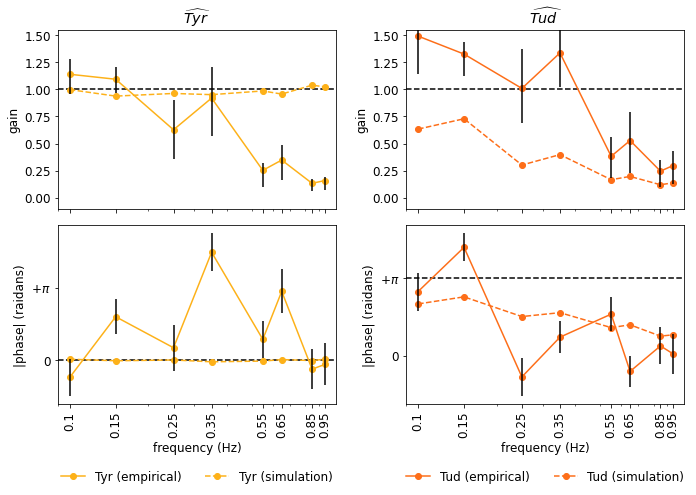

In [24]:
# plot Tyr and Tyd 
fig,axs = plt.subplots(2,2,figsize = (10,7),sharex=True)
xlim = (stimulated_freq[0]-.01,stimulated_freq[-1]+.1)
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)
ylimmag = (-1e-1,1.55)
yticksmag = [0.1,1,10]
# ylimphase = (-np.pi,np.pi)
# yticksphase = [-np.pi,0.,np.pi]
# yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']
ylimphase = (-0.4,np.pi+0.4)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'0',r'$+\pi$']

ax = axs[0,0]
ax.plot(stimulated_freq, Tyr_mag_mean, 'o-', color=colors['r'], label = 'Tyr measure')
ax.plot(stimulated_freq, Tyr_mag, 'o--', color=colors['r'], label = 'Tyr sim')
ax.errorbar(x=stimulated_freq, y=Tyr_mag_mean, xerr=None,
              yerr=np.asarray([Tyr_mag_mean-Tyr_mag_25, Tyr_mag_75-Tyr_mag_mean]),
              color='k',ls='none',zorder=10)
ax.plot(xlim,[1.,1.],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlim(xlim)
ax.set_ylim(ylimmag)
ax.set_ylabel('gain')
# ax.set_yticks(yticksmag) 
ax.title.set_text(r'$\widehat{Tyr}$') 

ax = axs[0,1]
ax.plot(stimulated_freq, Tud_mag_mean, 'o-', color=colors['d'], label = 'Tud (empirical)')
ax.plot(stimulated_freq, Tud_mag, 'o--', color=colors['d'], label = 'Tud (simulated)')
ax.errorbar(x=stimulated_freq, y=Tud_mag_mean, xerr=None,
              yerr=np.asarray([Tud_mag_mean-Tud_mag_25, Tud_mag_75-Tud_mag_mean]),
              color='k',ls='none',zorder=10)
# ax.plot(xlim,[0.,0.],'k--',zorder=-1)
ax.plot(xlim,[1.,1.],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlim(xlim)
ax.set_ylim(ylimmag)
ax.set_ylabel('gain')
# ax.set_yticks(yticksmag) 
ax.title.set_text(r'$\widehat{Tud}$') 

ax = axs[1,0]
ax.plot(stimulated_freq, Tyr_phase_mean, 'o-', color=colors['r'], label = 'Tyr (empirical)')
ax.plot(stimulated_freq, Tyr_phase, 'o--', color=colors['r'], label = 'Tyr (simulation)')
ax.errorbar(x=stimulated_freq, y=Tyr_phase_mean, xerr=None,
              yerr=np.asarray([Tyr_phase_mean-Tyr_phase_25, Tyr_phase_75-Tyr_phase_mean]),
              color='k',ls='none',zorder=10)
ax.plot(xlim,[0.,0.],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xlim(xlim)
# ax.set_ylim(ylimphase)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('|phase| (raidans)')
ax.set_yticks(yticksphase) 
ax.set_yticklabels(yticklabelsphase,**font)
ax.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol = 2, frameon = False)

ax = axs[1,1]
ax.plot(stimulated_freq, Tud_phase_mean, 'o-', color=colors['d'], label = 'Tud (empirical)')
ax.plot(stimulated_freq, Tud_phase, 'o--', color=colors['d'], label = 'Tud (simulation)')
ax.errorbar(x=stimulated_freq, y=Tud_phase_mean, xerr=None,
              yerr=np.asarray([Tud_phase_mean-Tud_phase_25, Tud_phase_75-Tud_phase_mean]),
              color='k',ls='none',zorder=10)
ax.plot(xlim,[np.pi,np.pi],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xlim(xlim)
# ax.set_ylim(ylimphase)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('|phase| (raidans)')
ax.set_yticks(yticksphase) 
ax.set_yticklabels(yticklabelsphase,**font)
ax.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol = 2, frameon = False)

# fig.suptitle(figname)
plt.tight_layout()
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Tyr and Tud of all 3 conditions

In [117]:
# mag & phase of simulated
Tyr_mag = np.abs(Tyr)
Tud_mag = np.abs(Tud)
Tyr_phase = np.angle(Tyr)
Tud_phase = np.angle(Tud)

# mag & phase of measured
Tyr_mag_mean = []
Tyr_mag_25 = []
Tyr_mag_75 = []

Tyr_phase_mean = []
Tyr_phase_25 = []
Tyr_phase_75 = []

Tud_mag_mean = []
Tud_mag_25 = []
Tud_mag_75 = []

Tud_phase_mean = []
Tud_phase_25 = []
Tud_phase_75 = []

for c in [0,1,2]:
    Tyr_mag_data = []
    Tyr_phase_data = []
    Tud_mag_data = []
    Tud_phase_data = []
    for p in range(participants_num):
        for i in range(trialnum[c]//2):
            Tyr_mag_data.append( np.abs(TF['TYR']['subject'+str(p)]['condition'+str(c)][i]) )
            Tyr_phase_data.append( np.angle(TF['TYR']['subject'+str(p)]['condition'+str(c)][i]) )
            Tud_mag_data.append(np.abs(TF['TUD']['subject'+str(p)]['condition'+str(c)][i]) )
            Tud_phase_data.append( np.angle(TF['TUD']['subject'+str(p)]['condition'+str(c)][i]) )

    Tyr_mag_mean.append( np.mean(Tyr_mag_data ,axis = 0) )
    Tyr_mag_25.append( np.percentile(Tyr_mag_data, 25, axis=0) )
    Tyr_mag_75.append( np.percentile(Tyr_mag_data, 75, axis=0) )

    Tyr_phase_mean.append( np.mean(Tyr_phase_data ,axis = 0) )
    Tyr_phase_25.append( np.percentile(Tyr_phase_data, 25, axis=0) )
    Tyr_phase_75.append( np.percentile(Tyr_phase_data, 75, axis=0) )

    Tud_mag_mean.append( np.mean(Tud_mag_data ,axis = 0) )
    Tud_mag_25.append( np.percentile(Tud_mag_data, 25, axis=0) )
    Tud_mag_75.append( np.percentile(Tud_mag_data, 75, axis=0) )

    Tud_phase_mean.append( np.mean(Tud_phase_data ,axis = 0) )
    Tud_phase_25.append( np.percentile(Tud_phase_data, 25, axis=0) )
    Tud_phase_75.append( np.percentile(Tud_phase_data, 75, axis=0) )

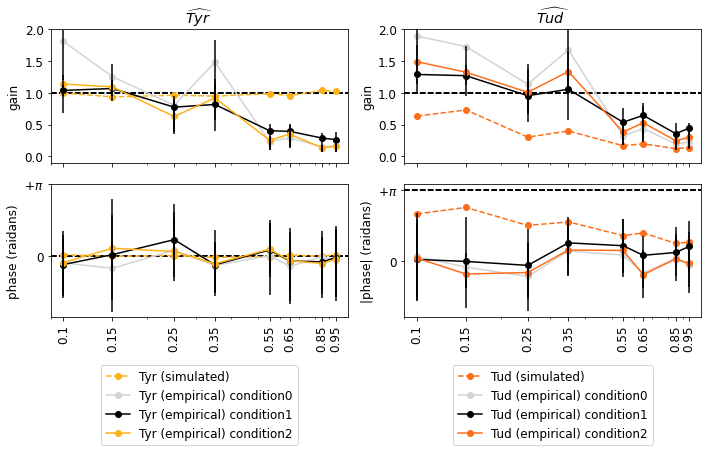

In [119]:
# plot Tyr and Tyd 
fig,axs = plt.subplots(2,2,figsize = (10,7),sharex=True)
xlim = (stimulated_freq[0]-.01,stimulated_freq[-1]+.1)
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)
ylimmag = (-1e-1,2)
yticksmag = [0.1,1,10]
ylimphase = (-0.4,np.pi+0.4)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'0',r'$+\pi$']
alphas = [0.2,0.6,1.0]
color_Tyr = ['lightgrey','black',colors['r']] #conditions 0,1,2
color_Tud = ['lightgrey','black',colors['d']]

ax = axs[0,0]
ax.plot(stimulated_freq, Tyr_mag, 'o--', color=colors['r'], label = 'Tyr sim')
ax = axs[0,1]
ax.plot(stimulated_freq, Tud_mag, 'o--', color=colors['d'], label = 'Tud (simulated)')
ax = axs[1,0]
ax.plot(stimulated_freq, Tyr_phase, 'o--', color=colors['r'], label = 'Tyr (simulated)')
ax = axs[1,1]
ax.plot(stimulated_freq, Tud_phase, 'o--', color=colors['d'], label = 'Tud (simulated)')

for c in [0,1,2]:
    ax = axs[0,0]
    ax.plot(stimulated_freq, Tyr_mag_mean[c], 'o-', color=color_Tyr[c], label = 'Tyr measure')
    ax.errorbar(x=stimulated_freq, y=Tyr_mag_mean[c], xerr=None,
                yerr=np.asarray([Tyr_mag_mean[c]-Tyr_mag_25[c], Tyr_mag_75[c]-Tyr_mag_mean[c]]),
                color='k',ls='none',zorder=10)
    ax.plot(xlim,[1.,1.],'k--',zorder=-1)
    ax.set_xscale("log")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylimmag)
    ax.set_ylabel('gain')
    # ax.set_yticks(yticksmag) 
    ax.title.set_text(r'$\widehat{Tyr}$') 

    ax = axs[0,1]
    ax.plot(stimulated_freq, Tud_mag_mean[c], 'o-', color=color_Tud[c], label = 'Tud (empirical)')
    ax.errorbar(x=stimulated_freq, y=Tud_mag_mean[c], xerr=None,
                yerr=np.asarray([Tud_mag_mean[c]-Tud_mag_25[c], Tud_mag_75[c]-Tud_mag_mean[c]]),
                color='k',ls='none',zorder=10)
    # ax.plot(xlim,[0.,0.],'k--',zorder=-1)
    ax.plot(xlim,[1.,1.],'k--',zorder=-1)
    ax.set_xscale("log")
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylimmag)
    ax.set_ylabel('gain')
    # ax.set_yticks(yticksmag) 
    ax.title.set_text(r'$\widehat{Tud}$') 

    ax = axs[1,0]
    ax.plot(stimulated_freq, Tyr_phase_mean[c], 'o-', color=color_Tyr[c], label = 'Tyr (empirical) condition'+str(c))
    ax.errorbar(x=stimulated_freq, y=Tyr_phase_mean[c], xerr=None,
                yerr=np.asarray([Tyr_phase_mean[c]-Tyr_phase_25[c], Tyr_phase_75[c]-Tyr_phase_mean[c]]),
                color='k',ls='none',zorder=10)
    ax.plot(xlim,[0.,0.],'k--',zorder=-1)
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    # ax.set_ylim(ylimphase)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=90)
    ax.set_ylabel('phase (raidans)')
    ax.set_yticks(yticksphase) 
    ax.set_yticklabels(yticklabelsphase,**font)

    ax = axs[1,1]
    ax.plot(stimulated_freq, Tud_phase_mean[c], 'o-', color=color_Tud[c], label = 'Tud (empirical) condition'+str(c))
    ax.errorbar(x=stimulated_freq, y=Tud_phase_mean[c], xerr=None,
                yerr=np.asarray([Tud_phase_mean[c]-Tud_phase_25[c], Tud_phase_75[c]-Tud_phase_mean[c]]),
                color='k',ls='none',zorder=10)
    ax.plot(xlim,[np.pi,np.pi],'k--',zorder=-1)
    ax.set_xscale("log")
    ax.set_xlim(xlim)
    # ax.set_ylim(ylimphase)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,rotation=90)
    ax.set_ylabel('|phase| (raidans)')
    ax.set_yticks(yticksphase) 
    ax.set_yticklabels(yticklabelsphase,**font)
    # fig.suptitle(figname)

axs[1,0].legend(bbox_to_anchor=(0.5, -1), loc='lower center')
axs[1,1].legend(bbox_to_anchor=(0.5, -1), loc='lower center')
plt.tight_layout()
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Ty0r and Tu0d

In [120]:
# mag & phase of simulated
Tyr_mag = np.abs(Tyr)
Tud_mag = np.abs(Tud)
Tyr_phase = np.angle(Tyr)
Tud_phase = np.angle(Tud)

# mag & phase of measured
Tyr_mag_data = []
Tyr_phase_data = []
Tud_mag_data = []
Tud_phase_data = []
# for p in range(participants_num):
#     Tyr_mag_p = np.mean(np.abs(TF['TY0R']['subject'+str(p)]['condition'+str(c)]) ,axis = 0) #mean of all trials of one participant
#     Tyr_mag_data.append( Tyr_mag_p )
#     Tyr_phase_p = np.mean(np.abs(np.angle(TF['TY0R']['subject'+str(p)]['condition'+str(c)])) ,axis = 0)
#     Tyr_phase_data.append( Tyr_phase_p )
    
#     Tud_mag_p = np.mean(np.abs(TF['TU0D']['subject'+str(p)]['condition'+str(c)]) ,axis = 0) #mean of all trials of one participant
#     Tud_mag_data.append( Tud_mag_p )
#     Tud_phase_p = np.mean(np.abs(np.angle(TF['TU0D']['subject'+str(p)]['condition'+str(c)])) ,axis = 0)
#     Tud_phase_data.append( Tud_phase_p )

for p in range(participants_num):
    for i in range(trialnum[c]//2):
        Tyr_mag_data.append( np.abs(TF['TY0R']['subject'+str(p)]['condition'+str(c)][i]) )
        Tyr_phase_data.append( np.angle(TF['TY0R']['subject'+str(p)]['condition'+str(c)][i]) )
        Tud_mag_data.append(np.abs(TF['TU0D']['subject'+str(p)]['condition'+str(c)][i]) )
        Tud_phase_data.append( np.angle(TF['TU0D']['subject'+str(p)]['condition'+str(c)][i]) )

Tyr_mag_mean = np.mean(Tyr_mag_data ,axis = 0)
Tyr_mag_25 = np.percentile(Tyr_mag_data, 25, axis=0)
Tyr_mag_75 = np.percentile(Tyr_mag_data, 75, axis=0)

Tyr_phase_mean = np.mean(Tyr_phase_data ,axis = 0)
Tyr_phase_25 = np.percentile(Tyr_phase_data, 25, axis=0)
Tyr_phase_75 = np.percentile(Tyr_phase_data, 75, axis=0)

Tud_mag_mean = np.mean(Tud_mag_data ,axis = 0)
Tud_mag_25 = np.percentile(Tud_mag_data, 25, axis=0)
Tud_mag_75 = np.percentile(Tud_mag_data, 75, axis=0)

Tud_phase_mean = np.mean(Tud_phase_data ,axis = 0)
Tud_phase_25 = np.percentile(Tud_phase_data, 25, axis=0)
Tud_phase_75 = np.percentile(Tud_phase_data, 75, axis=0)

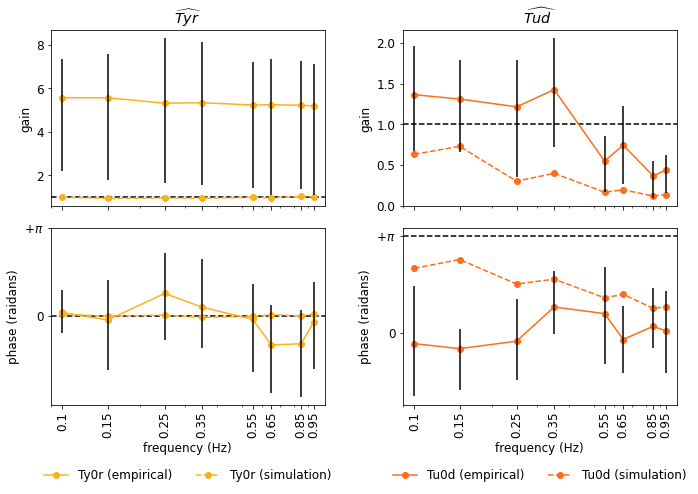

In [122]:
# plot Tyr and Tyd 
fig,axs = plt.subplots(2,2,figsize = (10,7),sharex=True)
xlim = (stimulated_freq[0]-.01,stimulated_freq[-1]+.1)
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)
ylimmag = (-1e-1,1.55)
yticksmag = [0.1,1,10]
# ylimphase = (-np.pi,np.pi)
# yticksphase = [-np.pi,0.,np.pi]
# yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']
ylimphase = (-0.4,np.pi+0.4)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'0',r'$+\pi$']

ax = axs[0,0]
ax.plot(stimulated_freq, Tyr_mag_mean, 'o-', color=colors['r'], label = 'Ty0r measure')
ax.plot(stimulated_freq, Tyr_mag, 'o--', color=colors['r'], label = 'Ty0r sim')
ax.errorbar(x=stimulated_freq, y=Tyr_mag_mean, xerr=None,
              yerr=np.asarray([Tyr_mag_mean-Tyr_mag_25, Tyr_mag_75-Tyr_mag_mean]),
              color='k',ls='none',zorder=10)
ax.plot(xlim,[1.,1.],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlim(xlim)
# ax.set_ylim(ylimmag)
ax.set_ylabel('gain')
# ax.set_yticks(yticksmag) 
ax.title.set_text(r'$\widehat{Tyr}$') 

ax = axs[0,1]
ax.plot(stimulated_freq, Tud_mag_mean, 'o-', color=colors['d'], label = 'Tu0d (empirical)')
ax.plot(stimulated_freq, Tud_mag, 'o--', color=colors['d'], label = 'Tu0d (simulated)')
ax.errorbar(x=stimulated_freq, y=Tud_mag_mean, xerr=None,
              yerr=np.asarray([Tud_mag_mean-Tud_mag_25, Tud_mag_75-Tud_mag_mean]),
              color='k',ls='none',zorder=10)
# ax.plot(xlim,[0.,0.],'k--',zorder=-1)
ax.plot(xlim,[1.,1.],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlim(xlim)
# ax.set_ylim(ylimmag)
ax.set_ylabel('gain')
# ax.set_yticks(yticksmag) 
ax.title.set_text(r'$\widehat{Tud}$') 

ax = axs[1,0]
ax.plot(stimulated_freq, Tyr_phase_mean, 'o-', color=colors['r'], label = 'Ty0r (empirical)')
ax.plot(stimulated_freq, Tyr_phase, 'o--', color=colors['r'], label = 'Ty0r (simulation)')
ax.errorbar(x=stimulated_freq, y=Tyr_phase_mean, xerr=None,
              yerr=np.asarray([Tyr_phase_mean-Tyr_phase_25, Tyr_phase_75-Tyr_phase_mean]),
              color='k',ls='none',zorder=10)
ax.plot(xlim,[0.,0.],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xlim(xlim)
# ax.set_ylim(ylimphase)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (raidans)')
ax.set_yticks(yticksphase) 
ax.set_yticklabels(yticklabelsphase,**font)
ax.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol = 2, frameon = False)

ax = axs[1,1]
ax.plot(stimulated_freq, Tud_phase_mean, 'o-', color=colors['d'], label = 'Tu0d (empirical)')
ax.plot(stimulated_freq, Tud_phase, 'o--', color=colors['d'], label = 'Tu0d (simulation)')
ax.errorbar(x=stimulated_freq, y=Tud_phase_mean, xerr=None,
              yerr=np.asarray([Tud_phase_mean-Tud_phase_25, Tud_phase_75-Tud_phase_mean]),
              color='k',ls='none',zorder=10)
ax.plot(xlim,[np.pi,np.pi],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xlim(xlim)
# ax.set_ylim(ylimphase)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (raidans)')
ax.set_yticks(yticksphase) 
ax.set_yticklabels(yticklabelsphase,**font)
ax.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol = 2, frameon = False)

# fig.suptitle(figname)
plt.tight_layout()
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Ty1r and Tu1d

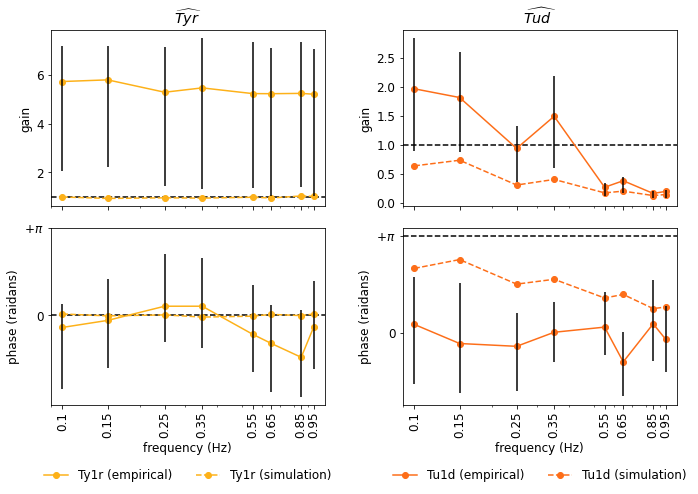

In [123]:
# mag & phase of simulated
Tyr_mag = np.abs(Tyr)
Tud_mag = np.abs(Tud)
Tyr_phase = np.angle(Tyr)
Tud_phase = np.angle(Tud)

# mag & phase of measured
Tyr_mag_data = []
Tyr_phase_data = []
Tud_mag_data = []
Tud_phase_data = []
# for p in range(participants_num):
#     Tyr_mag_p = np.mean(np.abs(TF['TY1R']['subject'+str(p)]['condition'+str(c)]) ,axis = 0) #mean of all trials of one participant
#     Tyr_mag_data.append( Tyr_mag_p )
#     Tyr_phase_p = np.mean(np.abs(np.angle(TF['TY1R']['subject'+str(p)]['condition'+str(c)])) ,axis = 0)
#     Tyr_phase_data.append( Tyr_phase_p )
    
#     Tud_mag_p = np.mean(np.abs(TF['TU1D']['subject'+str(p)]['condition'+str(c)]) ,axis = 0) #mean of all trials of one participant
#     Tud_mag_data.append( Tud_mag_p )
#     Tud_phase_p = np.mean(np.abs(np.angle(TF['TU1D']['subject'+str(p)]['condition'+str(c)])) ,axis = 0)
#     Tud_phase_data.append( Tud_phase_p )
for p in range(participants_num):
    for i in range(trialnum[c]//2):
        Tyr_mag_data.append( np.abs(TF['TY1R']['subject'+str(p)]['condition'+str(c)][i]) )
        Tyr_phase_data.append( np.angle(TF['TY1R']['subject'+str(p)]['condition'+str(c)][i]) )
        Tud_mag_data.append(np.abs(TF['TU1D']['subject'+str(p)]['condition'+str(c)][i]) )
        Tud_phase_data.append( np.angle(TF['TU1D']['subject'+str(p)]['condition'+str(c)][i]) )

Tyr_mag_mean = np.mean(Tyr_mag_data ,axis = 0)
Tyr_mag_25 = np.percentile(Tyr_mag_data, 25, axis=0)
Tyr_mag_75 = np.percentile(Tyr_mag_data, 75, axis=0)

Tyr_phase_mean = np.mean(Tyr_phase_data ,axis = 0)
Tyr_phase_25 = np.percentile(Tyr_phase_data, 25, axis=0)
Tyr_phase_75 = np.percentile(Tyr_phase_data, 75, axis=0)

Tud_mag_mean = np.mean(Tud_mag_data ,axis = 0)
Tud_mag_25 = np.percentile(Tud_mag_data, 25, axis=0)
Tud_mag_75 = np.percentile(Tud_mag_data, 75, axis=0)

Tud_phase_mean = np.mean(Tud_phase_data ,axis = 0)
Tud_phase_25 = np.percentile(Tud_phase_data, 25, axis=0)
Tud_phase_75 = np.percentile(Tud_phase_data, 75, axis=0)
# plot Tyr and Tyd 
fig,axs = plt.subplots(2,2,figsize = (10,7),sharex=True)
xlim = (stimulated_freq[0]-.01,stimulated_freq[-1]+.1)
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)
ylimmag = (-1e-1,1.55)
yticksmag = [0.1,1,10]
# ylimphase = (-np.pi,np.pi)
# yticksphase = [-np.pi,0.,np.pi]
# yticklabelsphase = [r'$-\pi$',r'0',r'$+\pi$']
ylimphase = (-0.4,np.pi+0.4)
yticksphase = [0.,np.pi]
yticklabelsphase = [r'0',r'$+\pi$']

ax = axs[0,0]
ax.plot(stimulated_freq, Tyr_mag_mean, 'o-', color=colors['r'], label = 'Ty1r measure')
ax.plot(stimulated_freq, Tyr_mag, 'o--', color=colors['r'], label = 'Ty1r sim')
ax.errorbar(x=stimulated_freq, y=Tyr_mag_mean, xerr=None,
              yerr=np.asarray([Tyr_mag_mean-Tyr_mag_25, Tyr_mag_75-Tyr_mag_mean]),
              color='k',ls='none',zorder=10)
ax.plot(xlim,[1.,1.],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlim(xlim)
# ax.set_ylim(ylimmag)
ax.set_ylabel('gain')
# ax.set_yticks(yticksmag) 
ax.title.set_text(r'$\widehat{Tyr}$') 

ax = axs[0,1]
ax.plot(stimulated_freq, Tud_mag_mean, 'o-', color=colors['d'], label = 'Tu1d (empirical)')
ax.plot(stimulated_freq, Tud_mag, 'o--', color=colors['d'], label = 'Tu1d (simulated)')
ax.errorbar(x=stimulated_freq, y=Tud_mag_mean, xerr=None,
              yerr=np.asarray([Tud_mag_mean-Tud_mag_25, Tud_mag_75-Tud_mag_mean]),
              color='k',ls='none',zorder=10)
# ax.plot(xlim,[0.,0.],'k--',zorder=-1)
ax.plot(xlim,[1.,1.],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlim(xlim)
# ax.set_ylim(ylimmag)
ax.set_ylabel('gain')
# ax.set_yticks(yticksmag) 
ax.title.set_text(r'$\widehat{Tud}$') 

ax = axs[1,0]
ax.plot(stimulated_freq, Tyr_phase_mean, 'o-', color=colors['r'], label = 'Ty1r (empirical)')
ax.plot(stimulated_freq, Tyr_phase, 'o--', color=colors['r'], label = 'Ty1r (simulation)')
ax.errorbar(x=stimulated_freq, y=Tyr_phase_mean, xerr=None,
              yerr=np.asarray([Tyr_phase_mean-Tyr_phase_25, Tyr_phase_75-Tyr_phase_mean]),
              color='k',ls='none',zorder=10)
ax.plot(xlim,[0.,0.],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xlim(xlim)
# ax.set_ylim(ylimphase)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (raidans)')
ax.set_yticks(yticksphase) 
ax.set_yticklabels(yticklabelsphase,**font)
ax.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol = 2, frameon = False)

ax = axs[1,1]
ax.plot(stimulated_freq, Tud_phase_mean, 'o-', color=colors['d'], label = 'Tu1d (empirical)')
ax.plot(stimulated_freq, Tud_phase, 'o--', color=colors['d'], label = 'Tu1d (simulation)')
ax.errorbar(x=stimulated_freq, y=Tud_phase_mean, xerr=None,
              yerr=np.asarray([Tud_phase_mean-Tud_phase_25, Tud_phase_75-Tud_phase_mean]),
              color='k',ls='none',zorder=10)
ax.plot(xlim,[np.pi,np.pi],'k--',zorder=-1)
ax.set_xscale("log")
ax.set_xlim(xlim)
# ax.set_ylim(ylimphase)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=90)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (raidans)')
ax.set_yticks(yticksphase) 
ax.set_yticklabels(yticklabelsphase,**font)
ax.legend(bbox_to_anchor=(0.5, -0.5), loc='lower center', ncol = 2, frameon = False)

# fig.suptitle(figname)
plt.tight_layout()
# plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# backups

## rk4

## generate dr and ddr

In [ ]:
refs = dict(sos=sos,zer=zero)

# vector fields
vfs = ['so']
scaleOut = 0.8120629258740933

# restart random generator
seed = 49
np.random.seed(seed)

period = 20 # sec
f_base = 1./period # Hz
# TODO go up to 3--5Hz -- check that Sam can track, and check when becomes sub-pixel
primes = np.asarray([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199])
f_max = dict(fo=2,so=1)
p_max = dict([(vf,np.nonzero(primes*f_base <= f_max[vf])[0][-1]+1) for vf in vfs])
f_primes = dict([(vf,np.asarray(primes[:p_max[vf]])) for vf in vfs])
#
frequencies = dict([(vf,f_primes[vf]*f_base) for vf in vfs])
frequencies_r = frequencies.copy()
frequencies_d = frequencies.copy()
#
#print 'p_max = ',p_max,', primes[p_max] = ',primes[p_max]
amplitudes = dict([(vf,scaleOut*(1./f_primes[vf])) for vf in vfs])
# amplitudes = dict([(vf,(1./f_primes[vf])*(0.5/f_primes[vf]).sum()) for vf in vfs])
amplitudes_r = amplitudes.copy()
# amplitudes_d = amplitudes.copy()
M = lambda s : 1/(s**2 + s) 
M_h = M(1.j*2*np.pi*frequencies_r['so'])
#d = Md/M
d = amplitudes_r['so'] / abs(M_h)
amplitudes_d = amplitudes.copy()
amplitudes_d['so'] = d

#
num_refs = 15 # will generate double the number of refs
phase_shifts_r = dict([(vf,np.random.sample((num_refs,p_max[vf]))) for vf in vfs])

# only first disturbance signal differs from reference signals
#print phase_shifts_r
phase_shifts_d = copy.deepcopy(phase_shifts_r)
shiftedPhase = {}
for vf in vfs:
    phase_shifts_d[vf][:] = phase_shifts_d[vf][:]*.8

In [ ]:
p = 0
c = 0
i = 9 #trial number

#empirical data (measured)
ref = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['r'][i]/scaleOutputScreen
dis = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['d'][i]/scaleInput
input = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['u'][i]/scaleInput
output = DATA['TIME']['subject'+str(p)]['condition'+str(c)]['y'][i]/scaleOutputScreen
ry = ref-output #r-y

#derivatives
sines_r = np.arange(p_max[vf])[0::2] #OE trial 0
shift_id = 4
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
p = phase_shifts_r[vf][shift_id][sines_r]
p = p.copy(); p.shape = (1,p.size)
r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)

#initial cond
b = 1
x0 = np.array([r[0],dr[0]])
uFF = lambda t: b*dr[int(t/dt)] + ddr[int(t/dt)] #b*dr + ddr  

def so(t,x,u):
  """
  second-order machine M
  # A = np.array([[0,1],[0,-b]])
  # B = np.array([[0],[1]])
  # C = np.array([1,0])
  """
  b = 1.0
  q,dq = x
  ddq = u
  return np.hstack((dq,ddq - b*dq))

# t_base,x_base = numerical_simulation(so,T,x0,t0=0.,dt=dt,ut=d)
  
t_,x_,u_ = numerical_simulation(so,T-dt*2,x0,t0=0.,dt=dt,ut=uFF,return_u=True)

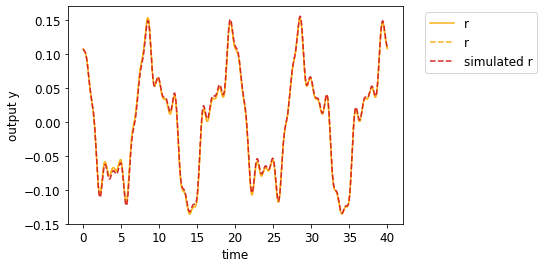

In [ ]:
# plt.plot(t-5,DATA['TIME']['subject0']['condition0']['y'][i],label='measured y',color= colors['y'])
plt.plot(t-5,ref*scaleOutputScreen,label='r',color= colors['r'])
plt.plot(t-5,r*scaleOutputScreen,'--',label='r',color= colors['r'])


plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated r',color= colors['RED'])

# plt.plot(t_base,x_base[:,0]*scaleOutputScreen,'--',label='baseline y')

# plt.plot(t-5,HCPS['subject0']['condition0']['trial0']['state_'][:,0],label='state q')
plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
#OE trial 0 # _ = sum_of_sines(t, trial, x, frequencies, amplitudes, phase_shifts, derivative)

sines_r = np.arange(p_max[vf])[0::2]
shift_id = 4
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
p = phase_shifts_r[vf][shift_id][sines_r]
p = p.copy(); p.shape = (1,p.size)

r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)


In [ ]:
#EO trial 0 # _ = sum_of_sines(t, trial, x, frequencies, amplitudes, phase_shifts, derivative)

sines_r = np.arange(p_max[vf])[1::2]
shift_id = 0
_t = np.asarray(t).copy(); _t.shape = (_t.size,1)
o = np.ones(_t.shape)
f = frequencies_r[vf][sines_r]
f = f.copy(); f.shape = (1,f.size)
a = amplitudes_r[vf][sines_r]
a = a.copy(); a.shape = (1,a.size)
p = phase_shifts_r[vf][shift_id][sines_r]
p = p.copy(); p.shape = (1,p.size)

r = np.sum(np.dot(o,a) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
dr = np.sum(np.dot(o,a) * 2*np.pi*np.dot(o,f) * np.cos(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)
ddr = np.sum(-np.dot(o,a) * 4*(np.pi*np.pi)*np.dot(o,f*f) * np.sin(2*np.pi*(np.dot(_t,f) + np.dot(o,p))),axis=1)


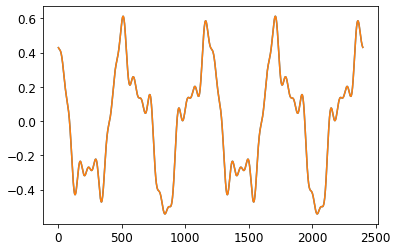

In [ ]:
plt.plot(r)
plt.plot(DATA['TIME']['subject'+str(0)]['condition'+str(0)]['r'][9]/scaleOutputScreen)

In [ ]:
# def rk_(f,t,x,dt=1.):
#     dx1 = f( t, x) * dt
#     dx2 = f( t+.5*dt, x+.5*dx1) * dt
#     dx3 = f( t+.5*dt, x+.5*dx2) * dt
#     dx4 = f( t+dt, x+dx3) * dt
#     dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
#     return dx #every x should be x-d[-1]

def rk_(f,t,dt=1.):
    dx1 = f( t, ) * dt
    dx2 = f( t+.5*dt) * dt
    dx3 = f( t+.5*dt) * dt
    dx4 = f( t+ dt) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]


# def so(t,x,u):
#   """
#   second-order machine M
#   # A = np.array([[0,1],[0,-b]])
#   # B = np.array([[0],[1]])
#   # C = np.array([1,0])
#   """
#   b = 1.0
#   q,dq = x
#   ddq = u
#   return np.hstack((dq,ddq - b*dq))


In [ ]:
ref = lambda t: DATA['TIME']['subject0']['condition0']['r'][i][int(t/dt)]
ry = lambda t: DATA['TIME']['subject0']['condition0']['r'][i][int(t/dt)]-DATA['TIME']['subject0']['condition0']['y'][i][int(t/dt)] #r-y

In [ ]:
ry0 = ry(0.)
ry0

-0.11402699868901989

In [ ]:
dry0 = rk_(ry,t=0.,dt=1.)
dry0

-0.19382685829709922

In [ ]:
dis = DATA['TIME']['subject0']['condition0']['d'][i]
input = DATA['TIME']['subject0']['condition0']['u'][i]
output = DATA['TIME']['subject0']['condition0']['y'][i]
r = DATA['TIME']['subject0']['condition0']['r'][i]

ry_ = r - output

ddref = np.diff(r,2)

In [ ]:
#simulation
def rk_(f,t,dt=1.):
    dx1 = f( t, ) * dt
    dx2 = f( t+.5*dt) * dt
    dx3 = f( t+.5*dt) * dt
    dx4 = f( t+ dt) * dt
    dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 )
    return dx #every x should be x-d[-1]
    
def uM(t):
    # u = input[int(t/dt)]#-np.dot(K,x)

    dref = rk_(ref,t,dt=1.)
    uM = (- input[int(t/dt)] - dis[int(t/dt)])/scaleInput + (b*dref + ddref[int(t/dt)])/scaleOutputScreen
    return uM

def sys(t,x,u):
    dx = A@x + B@u
    return np.hstack((dx[0],dx[1]))

x0 = np.array([ry0,dry0])/scaleOutputScreen #(r-q,dr-dq)

t_,x_ = numerical_simulation(sys,20.,x0,t0=0.,dt=dt,ut=uM)

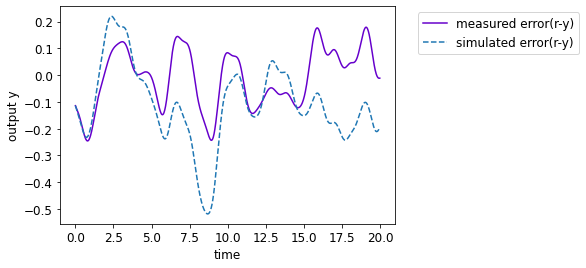

In [ ]:

plt.plot(t_,ry_[:1200],label='measured error(r-y)',color= colors['y'])

plt.plot(t_,x_[:,0]*scaleOutputScreen,'--',label='simulated error(r-y)')
# plt.plot(t_,x_[:,1]*scaleOutputScreen,'--',label='simulated error(dr-dy)')

plt.xlabel('time')
plt.ylabel('output y') #ouput y is that state q = x[:,0]
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()